In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [3]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/deep_learning/")
os.chdir("./sentiment_classification")
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
bow-cnn.hdf5		       output
count_vectorizer_weights.hdf5  polar.vocab
data			       Sentiment Analysis BOW-CNN.ipynb
data_stopwords		       Sentiment Analysis BOW_MLP-n-grams.ipynb
drive			       Sentiment Classification v1.ipynb
mlpv2.py


### Cleaning code does the following
> convert everything to lower case

> handle negations (convert \"don't\" to \"do not\")

> remove tokens that are not alphabetic

> filter stop words

> remove tokens less than 1 character


In [1]:
from string import punctuation
import os
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import re

import nltk
nltk.download('stopwords')

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def cleanv2(text):
	# convert to lower case
	text = text.lower()
	# change don't to do not, doesn't to does not
	text = neg_pattern.sub(lambda x: negations_dic[x.group()], text)
	# remove remaining tokens that are not alphabetic
	text = re.sub("[^a-zA-Z]", " ", text)
	# tokenize
	tokens = tokenizer.tokenize(text)
	# filter out words less than 1 character
	tokens = [word for word in tokens if len(word) > 1]
	return tokens	

# Function to create or fetch vocabulary
def make_vocab(vocabFile,directory='./sample'): #floyd
	vocabExists = os.path.isfile(vocabFile)
	if vocabExists:
		# Read and return vocab
		print("Found vocab file {}").format(vocabFile)
		vocab = load_doc(vocabFile)
		vocab = vocab.split('\n')
		print("Vocabulary has {} words").format(len(vocab))
	else:
		print("Did not find vocab file {}").format(vocabFile)
		vocab = Counter()
		# walk through all files in the folder
		for path, subdirs, files in os.walk(directory):
			for filename in files:
				# create the full path of the file to open
				filepath =  os.path.join(path, filename)
				# load and clean the doc
				doc = load_doc(filepath)
				tokens = cleanv2(doc)
				vocab.update(tokens)

		print("Number of tokens before filtering freqeuncy of occurance: {}").format(len(vocab))
		vocab = [word for word,freq in vocab.most_common() if freq>2]
		print("Number of tokens occuring more than 2 times: {}").format(len(vocab))
		
		# Save the vocabulary file
		# convert lines to a single blob of text
		data = '\n'.join(vocab)
		# open file
		file = open(vocabFile, 'w+')
		# write text
		print("Saving vocabulary to {}").format(vocabFile)
		file.write(data)
		# close file
		file.close()
	return vocab


# change all files to BoW representation 
# based on frequency of words in each review
# load all docs in a directory into memory
def process_reviews(directory,vocab):
	reviews = list()
	sentiment = list()
	# walk through all files in the folder
	for path, subdirs, files in os.walk(directory):
			for filename in files:
				# create the full path of the file to open
				filepath =  os.path.join(path, filename)
				# load the doc
				doc = load_doc(filepath)
				# clean doc
				tokens = cleanv2(doc)
				# filter by vocab
				tokens = [word for word in tokens if word in vocab]
				review = ' '.join(tokens)
				# append review to reviews
				reviews.append(review)
				# Get the sentiment as well
				sentiment.append(1 if 'pos' in filepath else 0)

	return reviews,sentiment


def get_data(data_file,isTrain=True):
	dataset_type = 'train' if isTrain else 'test'
	if os.path.isfile(data_file):
		print("Found "+dataset_type+" File {}.").format(data_file)
		data = pickle.load(open(data_file, 'rb'))
		X,y = zip(*data)


	else:
		print("Did not find "+dataset_type+" file.")
		vocab = make_vocab('./data_stopwords/polar.vocab','./dataset/train')#floyd
		print("Saved Vocabulary")
		print("processing reviews...")
		X,y = process_reviews('./dataset/'+dataset_type,vocab) #floyd
		data = zip(np.array(X),np.array(y))
		np.array(data).dump('./output/'+dataset_type+'.data') #floyd

	X = np.array(X)
	y = np.array(y)
	print("Found {} samples for "+dataset_type).format(X.shape[0])

	return X,y

def ngram_tokenize(X_train,X_test,max_features=None,ngram=(1,1)):
  from sklearn.feature_extraction.text import CountVectorizer
  vectorizer = CountVectorizer(analyzer = "word", 
                               ngram_range = ngram,
                               binary=False, # If True it is frequency else binary
                               max_features = max_features) 
  vectorizer.fit(X_train)
  X_train = vectorizer.transform(X_train)
  X_test = vectorizer.transform(X_test)
  #print vectorizer.vocabulary_
  return X_train,X_test

def train_model(model, X,y,epochs=10):
	from keras.callbacks import ModelCheckpoint
	X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=30)
	save_model = ModelCheckpoint('bow-cnn.hdf5', monitor='val_loss',save_best_only=True)
	hist = model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=1, callbacks=[save_model],validation_data=(X_val,y_val),shuffle=True )
	return hist

def test_model(model, X_test, y_test):
	print("Testing model on {}").format(X_test.shape[0])
	model.load_weights('bow-cnn.hdf5') #floyd
	loss, acc = model.evaluate(X_test, y_test, verbose=0)
	print('Test Accuracy: %f' % (acc*100))

def plot_loss(hist):
	import matplotlib.pyplot as plt
	loss = hist.history['loss'] #np.loadtxt('my_cnn_model_loss.csv')
	val_loss = hist.history['val_loss'] #np.loadtxt('my_cnn_model_val_loss.csv')

	plt.plot(loss, linewidth=3, label='train')
	plt.plot(val_loss, linewidth=3, label='valid')
	plt.grid()
	plt.legend()
	plt.xlabel('epoch')
	plt.ylabel('loss')
	#plt.ylim(1e-3, 1e-2)
	plt.yscale('log')
	plt.show()

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### With stop words.

In [3]:
train_file = './data_stopwords/train.data' #floyd
test_file = './data_stopwords/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

print("Tokenizing")
X,X_test = ngram_tokenize(X,X_test,max_features=8000,ngram=(1,1))
print(X.shape)
print(X_test.shape)

Found train File ./data_stopwords/train.data.
Found 25000 samples for train
Found test File ./data_stopwords/test.data.
Found 25000 samples for test
Tokenizing
(25000, 8000)
(25000, 8000)


In [0]:
def cnn_modelv1(input_shape):

	from keras.models import Model
	from keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Flatten

	input_layer = Input(shape=(input_shape[1],input_shape[2],))
	x = Conv1D(64, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
			kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
			bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_layer)
	x = MaxPooling1D(pool_size=3, strides=None, padding='valid')(x)
	
	x = Flatten()(x)
	x = Dense(50,activation='relu')(x)
	x = Dropout(0.7)(x)
	# x = Dense(128,activation='relu')(x)
	# x = Dropout(0.5)(x)
	output_layer = Dense(1,activation='sigmoid')(x)
	model = Model(inputs=input_layer, outputs=output_layer)

	model.summary()

	return model

(25000, 8000)
(25000, 8000, 1)
(25000, 8000, 1)
(25000, 8000, 1)


Using TensorFlow backend.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3999, 64)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 799, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51136)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               25568500  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
___________________________________________________________

20000/20000 [==============================] - 38s 2ms/step - loss: 0.4681 - acc: 0.7928 - val_loss: 0.3717 - val_acc: 0.8386
Epoch 2/20
 7520/20000 [==========>...................] - ETA: 21s - loss: 0.3673 - acc: 0.8408

20000/20000 [==============================] - 36s 2ms/step - loss: 0.3732 - acc: 0.8407 - val_loss: 0.3486 - val_acc: 0.8504
Epoch 3/20
 9696/20000 [=============>................] - ETA: 18s - loss: 0.3309 - acc: 0.8579

20000/20000 [==============================] - 36s 2ms/step - loss: 0.3396 - acc: 0.8538 - val_loss: 0.3561 - val_acc: 0.8444
Epoch 4/20
10560/20000 [==============>...............] - ETA: 16s - loss: 0.3208 - acc: 0.8681

20000/20000 [==============================] - 36s 2ms/step - loss: 0.3228 - acc: 0.8650 - val_loss: 0.3571 - val_acc: 0.8484
Epoch 5/20
10880/20000 [===============>..............] - ETA: 15s - loss: 0.2971 - acc: 0.8775

20000/20000 [==============================] - 36s 2ms/step - loss: 0.3037 - acc: 0.8746 - val_loss: 0.3495 - val_acc: 0.8468
Epoch 6/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.2870 - acc: 0.8825

20000/20000 [==============================] - 36s 2ms/step - loss: 0.2910 - acc: 0.8789 - val_loss: 0.3621 - val_acc: 0.8440
Epoch 7/20
11040/20000 [===============>..............] - ETA: 15s - loss: 0.2704 - acc: 0.8862

20000/20000 [==============================] - 36s 2ms/step - loss: 0.2738 - acc: 0.8850 - val_loss: 0.3592 - val_acc: 0.8458
Epoch 8/20
11072/20000 [===============>..............] - ETA: 15s - loss: 0.2511 - acc: 0.8988

20000/20000 [==============================] - 36s 2ms/step - loss: 0.2578 - acc: 0.8945 - val_loss: 0.3716 - val_acc: 0.8490
Epoch 9/20
11072/20000 [===============>..............] - ETA: 15s - loss: 0.2355 - acc: 0.9020

20000/20000 [==============================] - 36s 2ms/step - loss: 0.2441 - acc: 0.9000 - val_loss: 0.3826 - val_acc: 0.8468
Epoch 10/20
11040/20000 [===============>..............] - ETA: 15s - loss: 0.2241 - acc: 0.9094

20000/20000 [==============================] - 36s 2ms/step - loss: 0.2269 - acc: 0.9084 - val_loss: 0.3954 - val_acc: 0.8442
Epoch 11/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.2180 - acc: 0.9152

20000/20000 [==============================] - 36s 2ms/step - loss: 0.2206 - acc: 0.9125 - val_loss: 0.3821 - val_acc: 0.8484
Epoch 12/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1984 - acc: 0.9211

20000/20000 [==============================] - 36s 2ms/step - loss: 0.2044 - acc: 0.9189 - val_loss: 0.4382 - val_acc: 0.8480
Epoch 13/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1933 - acc: 0.9251

20000/20000 [==============================] - 36s 2ms/step - loss: 0.1952 - acc: 0.9225 - val_loss: 0.4396 - val_acc: 0.8382
Epoch 14/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1767 - acc: 0.9281

20000/20000 [==============================] - 36s 2ms/step - loss: 0.1867 - acc: 0.9241 - val_loss: 0.4370 - val_acc: 0.8452
Epoch 15/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1691 - acc: 0.9357

20000/20000 [==============================] - 36s 2ms/step - loss: 0.1738 - acc: 0.9325 - val_loss: 0.4688 - val_acc: 0.8488
Epoch 16/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1551 - acc: 0.9404

20000/20000 [==============================] - 36s 2ms/step - loss: 0.1616 - acc: 0.9363 - val_loss: 0.4633 - val_acc: 0.8450
Epoch 17/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1528 - acc: 0.9382

20000/20000 [==============================] - 36s 2ms/step - loss: 0.1559 - acc: 0.9367 - val_loss: 0.4701 - val_acc: 0.8478
Epoch 18/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1461 - acc: 0.9415

20000/20000 [==============================] - 36s 2ms/step - loss: 0.1535 - acc: 0.9397 - val_loss: 0.4880 - val_acc: 0.8482
Epoch 19/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1428 - acc: 0.9425

20000/20000 [==============================] - 36s 2ms/step - loss: 0.1451 - acc: 0.9419 - val_loss: 0.4999 - val_acc: 0.8448
Epoch 20/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1329 - acc: 0.9459

20000/20000 [==============================] - 36s 2ms/step - loss: 0.1410 - acc: 0.9438 - val_loss: 0.4711 - val_acc: 0.8438
Testing model on 25000
Test Accuracy: 84.804000


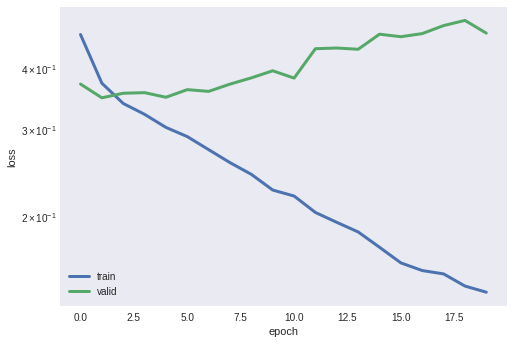

In [5]:
X = X.toarray()
print(X.shape)
X = X.reshape((X.shape[0],X.shape[1],1))
print(X.shape)

X_test = X_test.toarray()
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print(X.shape)
print(X_test.shape)

model = cnn_modelv1(input_shape=X.shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=20)
test_model(model,X_test,y_test)
plot_loss(hist)

### **Without Stop words**

In [29]:
train_file = './data/train.data' #floyd
test_file = './data/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

print("Tokenizing")
X,X_test = ngram_tokenize(X,X_test,max_features=6000,ngram=(1,1))
print(X.shape)
print(X_test.shape)

Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test
Tokenizing
(25000, 6000)
(25000, 6000)


(25000, 6000)
(25000, 6000, 1)
(25000, 6000, 1)
(25000, 6000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 6000, 1)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5998, 64)          256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2999, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 191936)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                9596850   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (De

20000/20000 [==============================] - 38s 2ms/step - loss: 0.3785 - acc: 0.8371 - val_loss: 0.3452 - val_acc: 0.8524
Epoch 2/20
 7680/20000 [==========>...................] - ETA: 21s - loss: 0.2539 - acc: 0.9001

20000/20000 [==============================] - 38s 2ms/step - loss: 0.2668 - acc: 0.8929 - val_loss: 0.3202 - val_acc: 0.8736
Epoch 3/20
 9792/20000 [=============>................] - ETA: 17s - loss: 0.2006 - acc: 0.9218

20000/20000 [==============================] - 38s 2ms/step - loss: 0.2158 - acc: 0.9157 - val_loss: 0.3336 - val_acc: 0.8704
Epoch 4/20
10592/20000 [==============>...............] - ETA: 16s - loss: 0.1681 - acc: 0.9339

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1698 - acc: 0.9331 - val_loss: 0.4051 - val_acc: 0.8662
Epoch 5/20
10880/20000 [===============>..............] - ETA: 15s - loss: 0.1440 - acc: 0.9452

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1470 - acc: 0.9440 - val_loss: 0.4109 - val_acc: 0.8648
Epoch 6/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1175 - acc: 0.9535

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1263 - acc: 0.9497 - val_loss: 0.4425 - val_acc: 0.8710
Epoch 7/20
11040/20000 [===============>..............] - ETA: 15s - loss: 0.1093 - acc: 0.9556

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1162 - acc: 0.9535 - val_loss: 0.4751 - val_acc: 0.8680
Epoch 8/20
11072/20000 [===============>..............] - ETA: 15s - loss: 0.1002 - acc: 0.9604

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1030 - acc: 0.9585 - val_loss: 0.5171 - val_acc: 0.8724
Epoch 9/20
11072/20000 [===============>..............] - ETA: 15s - loss: 0.0920 - acc: 0.9633

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0990 - acc: 0.9611 - val_loss: 0.4758 - val_acc: 0.8690
Epoch 10/20
11040/20000 [===============>..............] - ETA: 15s - loss: 0.0830 - acc: 0.9667

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0867 - acc: 0.9645 - val_loss: 0.5407 - val_acc: 0.8676
Epoch 11/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0707 - acc: 0.9694

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0782 - acc: 0.9684 - val_loss: 0.5502 - val_acc: 0.8622
Epoch 12/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0750 - acc: 0.9686

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0776 - acc: 0.9676 - val_loss: 0.5674 - val_acc: 0.8602
Epoch 13/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0698 - acc: 0.9712

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0712 - acc: 0.9704 - val_loss: 0.6058 - val_acc: 0.8632
Epoch 14/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0627 - acc: 0.9733

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0685 - acc: 0.9716 - val_loss: 0.5849 - val_acc: 0.8622
Epoch 15/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0661 - acc: 0.9710

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0660 - acc: 0.9711 - val_loss: 0.6417 - val_acc: 0.8662
Epoch 16/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0622 - acc: 0.9750

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0674 - acc: 0.9731 - val_loss: 0.5823 - val_acc: 0.8640
Epoch 17/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0543 - acc: 0.9764

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0589 - acc: 0.9753 - val_loss: 0.6202 - val_acc: 0.8694
Epoch 18/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0578 - acc: 0.9744

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0631 - acc: 0.9724 - val_loss: 0.6557 - val_acc: 0.8708
Epoch 19/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0580 - acc: 0.9753

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0615 - acc: 0.9750 - val_loss: 0.6351 - val_acc: 0.8646
Epoch 20/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0497 - acc: 0.9782

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0523 - acc: 0.9773 - val_loss: 0.6621 - val_acc: 0.8678
Testing model on 25000
Test Accuracy: 86.692000


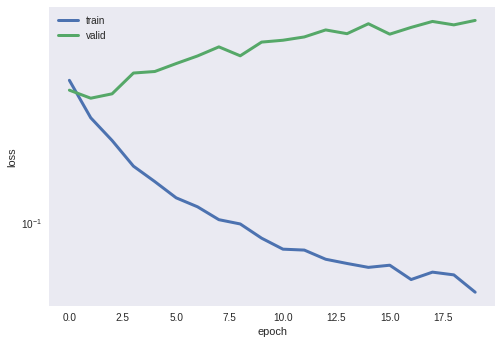

In [30]:
X = X.toarray()
print(X.shape)
X = X.reshape((X.shape[0],X.shape[1],1))
print(X.shape)

X_test = X_test.toarray()
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print(X.shape)
print(X_test.shape)

model = cnn_modelv1(input_shape=X.shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=20)
test_model(model,X_test,y_test)
plot_loss(hist)

### Increasing number of CNN layers

In [4]:
train_file = './data_stopwords/train.data' #floyd
test_file = './data_stopwords/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

print("Tokenizing")
X,X_test = ngram_tokenize(X,X_test,max_features=5000,ngram=(1,1))

X = X.toarray()
X = X.reshape((X.shape[0],X.shape[1],1))

X_test = X_test.toarray()
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print(X.shape)
print(X_test.shape)

Found train File ./data_stopwords/train.data.
Found 25000 samples for train
Found test File ./data_stopwords/test.data.
Found 25000 samples for test
Tokenizing
(25000, 5000, 1)
(25000, 5000, 1)


Using TensorFlow backend.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4998, 16)          64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2499, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2497, 32)          1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1248, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 39936)             0         
___________________________________________________________

20000/20000 [==============================] - 21s 1ms/step - loss: 0.4022 - acc: 0.8262 - val_loss: 0.3234 - val_acc: 0.8670
Epoch 2/20
20000/20000 [==============================] - 20s 986us/step - loss: 0.2783 - acc: 0.8860 - val_loss: 0.3264 - val_acc: 0.8642
Epoch 3/20
 1504/20000 [=>............................] - ETA: 16s - loss: 0.2345 - acc: 0.9129

20000/20000 [==============================] - 19s 971us/step - loss: 0.2278 - acc: 0.9082 - val_loss: 0.3217 - val_acc: 0.8676
Epoch 4/20
20000/20000 [==============================] - 20s 984us/step - loss: 0.1832 - acc: 0.9274 - val_loss: 0.3720 - val_acc: 0.8680
Epoch 5/20
  992/20000 [>.............................] - ETA: 17s - loss: 0.1413 - acc: 0.9466

20000/20000 [==============================] - 19s 974us/step - loss: 0.1434 - acc: 0.9465 - val_loss: 0.3812 - val_acc: 0.8680
Epoch 6/20
20000/20000 [==============================] - 19s 969us/step - loss: 0.1064 - acc: 0.9586 - val_loss: 0.4225 - val_acc: 0.8642
Epoch 7/20
  864/20000 [>.............................] - ETA: 17s - loss: 0.0707 - acc: 0.9838

20000/20000 [==============================] - 19s 971us/step - loss: 0.0775 - acc: 0.9716 - val_loss: 0.4677 - val_acc: 0.8626
Epoch 8/20
20000/20000 [==============================] - 19s 972us/step - loss: 0.0663 - acc: 0.9755 - val_loss: 0.4921 - val_acc: 0.8676
Epoch 9/20
  864/20000 [>.............................] - ETA: 17s - loss: 0.0494 - acc: 0.9803

20000/20000 [==============================] - 19s 968us/step - loss: 0.0591 - acc: 0.9783 - val_loss: 0.5415 - val_acc: 0.8626
Epoch 10/20
20000/20000 [==============================] - 20s 975us/step - loss: 0.0540 - acc: 0.9805 - val_loss: 0.5569 - val_acc: 0.8624
Epoch 11/20
  800/20000 [>.............................] - ETA: 17s - loss: 0.0255 - acc: 0.9900

20000/20000 [==============================] - 19s 971us/step - loss: 0.0403 - acc: 0.9858 - val_loss: 0.6063 - val_acc: 0.8668
Epoch 12/20
20000/20000 [==============================] - 19s 974us/step - loss: 0.0410 - acc: 0.9843 - val_loss: 0.6280 - val_acc: 0.8612
Epoch 13/20
  800/20000 [>.............................] - ETA: 17s - loss: 0.0179 - acc: 0.9938

20000/20000 [==============================] - 19s 971us/step - loss: 0.0365 - acc: 0.9871 - val_loss: 0.6339 - val_acc: 0.8624
Epoch 14/20
20000/20000 [==============================] - 19s 973us/step - loss: 0.0348 - acc: 0.9873 - val_loss: 0.6679 - val_acc: 0.8654
Epoch 15/20
  800/20000 [>.............................] - ETA: 17s - loss: 0.0263 - acc: 0.9900

20000/20000 [==============================] - 19s 972us/step - loss: 0.0348 - acc: 0.9869 - val_loss: 0.6040 - val_acc: 0.8608
Epoch 16/20
20000/20000 [==============================] - 19s 972us/step - loss: 0.0327 - acc: 0.9880 - val_loss: 0.6381 - val_acc: 0.8620
Epoch 17/20
  800/20000 [>.............................] - ETA: 18s - loss: 0.0292 - acc: 0.9888

20000/20000 [==============================] - 20s 977us/step - loss: 0.0282 - acc: 0.9896 - val_loss: 0.7236 - val_acc: 0.8668
Epoch 18/20
20000/20000 [==============================] - 19s 973us/step - loss: 0.0289 - acc: 0.9895 - val_loss: 0.7110 - val_acc: 0.8680
Epoch 19/20
  800/20000 [>.............................] - ETA: 17s - loss: 0.0215 - acc: 0.9938

20000/20000 [==============================] - 19s 970us/step - loss: 0.0284 - acc: 0.9897 - val_loss: 0.6752 - val_acc: 0.8668
Epoch 20/20
20000/20000 [==============================] - 19s 970us/step - loss: 0.0252 - acc: 0.9912 - val_loss: 0.6977 - val_acc: 0.8624
Testing model on 25000
Test Accuracy: 87.356000


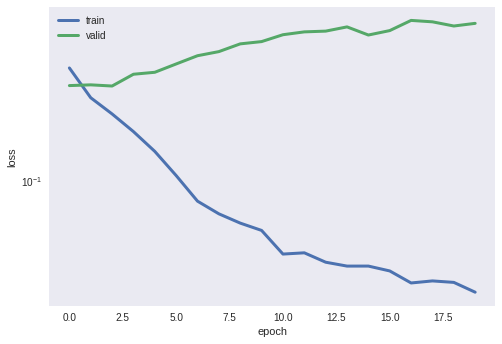

In [5]:
def cnn_modelv2(input_shape):

  from keras.models import Model
  from keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Flatten

  input_layer = Input(shape=(input_shape[1],input_shape[2],))
  x = Conv1D(16, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_layer)
  x = MaxPooling1D(pool_size=2, strides=None, padding='valid')(x)

  x = Conv1D(32, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = MaxPooling1D(pool_size=2, strides=None, padding='valid')(x)

  x = Flatten()(x)
  x = Dense(200,activation='relu')(x)
  x = Dropout(0.5)(x)
  # x = Dense(128,activation='relu')(x)
  # x = Dropout(0.5)(x)
  output_layer = Dense(1,activation='sigmoid')(x)
  model = Model(inputs=input_layer, outputs=output_layer)

  model.summary()

  return model

model = cnn_modelv2(input_shape=X.shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=20)
test_model(model,X_test,y_test)
plot_loss(hist)

### Using Softmax instead of sigmoid

In [4]:
train_file = './data_stopwords/train.data' #floyd
test_file = './data_stopwords/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

print("Tokenizing")
X,X_test = ngram_tokenize(X,X_test,max_features=8000,ngram=(1,1))
print(X.shape)
print(X_test.shape)

Found train File ./data_stopwords/train.data.
Found 25000 samples for train
Found test File ./data_stopwords/test.data.
Found 25000 samples for test
Tokenizing
(25000, 8000)
(25000, 8000)


In [0]:
def cnn_modelv3(input_shape):

  from keras.models import Model
  from keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Flatten,AveragePooling1D

  input_layer = Input(shape=(input_shape[1],input_shape[2],))
  x = Conv1D(32, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_layer)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)


  x = Flatten()(x)
  x = Dropout(0.7)(x)
  x = Dense(500,activation='relu')(x)
  x = Dropout(0.7)(x)
  # x = Dense(128,activation='relu')(x)
  # x = Dropout(0.5)(x)
  output_layer = Dense(2,activation='softmax')(x)
  model = Model(inputs=input_layer, outputs=output_layer)

  model.summary()

  return model


Using 16 and 64 filters did not improve results, 32 filters gave the best results

In [0]:
# One-hot encoding is required for softmax
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
y = y.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y = enc.fit_transform(y)
y_test = enc.fit_transform(y_test)
# [0->for negative 1-> for positive]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 7998, 32)          128       
_________________________________________________________________
average_pooling1d_6 (Average (None, 2666, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 85312)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 85312)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               42656500  
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)               0         
__________

20000/20000 [==============================] - 51s 3ms/step - loss: 0.4399 - acc: 0.8042 - val_loss: 0.3230 - val_acc: 0.8672
Epoch 2/20
 7616/20000 [==========>...................] - ETA: 31s - loss: 0.3417 - acc: 0.8612

20000/20000 [==============================] - 51s 3ms/step - loss: 0.3338 - acc: 0.8640 - val_loss: 0.3199 - val_acc: 0.8722
Epoch 3/20
 9760/20000 [=============>................] - ETA: 25s - loss: 0.3096 - acc: 0.8708

20000/20000 [==============================] - 51s 3ms/step - loss: 0.3088 - acc: 0.8745 - val_loss: 0.3080 - val_acc: 0.8758
Epoch 4/20
10560/20000 [==============>...............] - ETA: 23s - loss: 0.2873 - acc: 0.8812

20000/20000 [==============================] - 51s 3ms/step - loss: 0.2851 - acc: 0.8823 - val_loss: 0.3166 - val_acc: 0.8760
Epoch 5/20
10880/20000 [===============>..............] - ETA: 22s - loss: 0.2588 - acc: 0.8971

20000/20000 [==============================] - 51s 3ms/step - loss: 0.2692 - acc: 0.8914 - val_loss: 0.3095 - val_acc: 0.8744
Epoch 6/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.2560 - acc: 0.8939

20000/20000 [==============================] - 51s 3ms/step - loss: 0.2574 - acc: 0.8928 - val_loss: 0.3001 - val_acc: 0.8808
Epoch 7/20
11040/20000 [===============>..............] - ETA: 22s - loss: 0.2375 - acc: 0.9068

20000/20000 [==============================] - 51s 3ms/step - loss: 0.2474 - acc: 0.9009 - val_loss: 0.3074 - val_acc: 0.8766
Epoch 8/20
11072/20000 [===============>..............] - ETA: 21s - loss: 0.2354 - acc: 0.9025

20000/20000 [==============================] - 51s 3ms/step - loss: 0.2423 - acc: 0.8995 - val_loss: 0.3058 - val_acc: 0.8780
Epoch 9/20
11072/20000 [===============>..............] - ETA: 21s - loss: 0.2180 - acc: 0.9140

20000/20000 [==============================] - 51s 3ms/step - loss: 0.2218 - acc: 0.9126 - val_loss: 0.3163 - val_acc: 0.8716
Epoch 10/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.2129 - acc: 0.9155

20000/20000 [==============================] - 51s 3ms/step - loss: 0.2137 - acc: 0.9148 - val_loss: 0.3071 - val_acc: 0.8794
Epoch 11/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.2020 - acc: 0.9181

20000/20000 [==============================] - 50s 3ms/step - loss: 0.2054 - acc: 0.9162 - val_loss: 0.3135 - val_acc: 0.8746
Epoch 12/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.1890 - acc: 0.9259

20000/20000 [==============================] - 51s 3ms/step - loss: 0.1955 - acc: 0.9224 - val_loss: 0.3168 - val_acc: 0.8770
Epoch 13/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.1924 - acc: 0.9232

20000/20000 [==============================] - 51s 3ms/step - loss: 0.1934 - acc: 0.9239 - val_loss: 0.3244 - val_acc: 0.8764
Epoch 14/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.1784 - acc: 0.9310

20000/20000 [==============================] - 51s 3ms/step - loss: 0.1807 - acc: 0.9289 - val_loss: 0.3598 - val_acc: 0.8758
Epoch 15/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.1680 - acc: 0.9363

20000/20000 [==============================] - 51s 3ms/step - loss: 0.1743 - acc: 0.9329 - val_loss: 0.3602 - val_acc: 0.8656
Epoch 16/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.1716 - acc: 0.9330

20000/20000 [==============================] - 51s 3ms/step - loss: 0.1696 - acc: 0.9335 - val_loss: 0.3467 - val_acc: 0.8752
Epoch 17/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.1573 - acc: 0.9401

20000/20000 [==============================] - 51s 3ms/step - loss: 0.1583 - acc: 0.9385 - val_loss: 0.3406 - val_acc: 0.8798
Epoch 18/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.1522 - acc: 0.9410

20000/20000 [==============================] - 51s 3ms/step - loss: 0.1539 - acc: 0.9396 - val_loss: 0.3623 - val_acc: 0.8778
Epoch 19/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.1475 - acc: 0.9462

20000/20000 [==============================] - 51s 3ms/step - loss: 0.1456 - acc: 0.9449 - val_loss: 0.3865 - val_acc: 0.8820
Epoch 20/20
11008/20000 [===============>..............] - ETA: 21s - loss: 0.1427 - acc: 0.9437

20000/20000 [==============================] - 51s 3ms/step - loss: 0.1431 - acc: 0.9448 - val_loss: 0.3604 - val_acc: 0.8782
Testing model on 25000
Test Accuracy: 87.888000


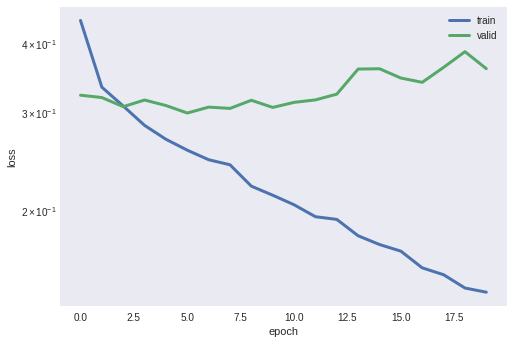

In [17]:
# X = X.toarray()
# X = X.reshape((X.shape[0],X.shape[1],1))

# X_test = X_test.toarray()
# X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

# print(X.shape)
# print(X_test.shape)



model = cnn_modelv3(input_shape=X.shape)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=20)
test_model(model,X_test,y_test)
plot_loss(hist)

#### Trying deeper networks

In [0]:
def cnn_modelv4(input_shape):

  from keras.models import Model
  from keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Flatten,AveragePooling1D

  input_layer = Input(shape=(input_shape[1],input_shape[2],))
  x = Conv1D(32, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_layer)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Conv1D(64, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Flatten()(x)
  x = Dropout(0.7)(x)
  x = Dense(500,activation='relu')(x)
  x = Dropout(0.7)(x)
  # x = Dense(128,activation='relu')(x)
  # x = Dropout(0.5)(x)
  output_layer = Dense(2,activation='softmax')(x)
  model = Model(inputs=input_layer, outputs=output_layer)

  model.summary()

  return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 8000, 1)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 7998, 32)          128       
_________________________________________________________________
average_pooling1d_21 (Averag (None, 2666, 32)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 2664, 64)          6208      
_________________________________________________________________
average_pooling1d_22 (Averag (None, 888, 64)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 56832)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 56832)             0         
__________

20000/20000 [==============================] - 43s 2ms/step - loss: 0.4735 - acc: 0.7881 - val_loss: 0.3860 - val_acc: 0.8316
Epoch 2/20
 7168/20000 [=========>....................] - ETA: 26s - loss: 0.3742 - acc: 0.8382

20000/20000 [==============================] - 43s 2ms/step - loss: 0.3647 - acc: 0.8454 - val_loss: 0.3369 - val_acc: 0.8578
Epoch 3/20
 8832/20000 [============>.................] - ETA: 23s - loss: 0.3232 - acc: 0.8615

20000/20000 [==============================] - 44s 2ms/step - loss: 0.3282 - acc: 0.8584 - val_loss: 0.3285 - val_acc: 0.8658
Epoch 4/20
 9920/20000 [=============>................] - ETA: 20s - loss: 0.3130 - acc: 0.8691

20000/20000 [==============================] - 43s 2ms/step - loss: 0.3100 - acc: 0.8690 - val_loss: 0.3203 - val_acc: 0.8680
Epoch 5/20
10528/20000 [==============>...............] - ETA: 19s - loss: 0.2902 - acc: 0.8748

20000/20000 [==============================] - 43s 2ms/step - loss: 0.2927 - acc: 0.8728 - val_loss: 0.3214 - val_acc: 0.8664
Epoch 6/20
10464/20000 [==============>...............] - ETA: 19s - loss: 0.2724 - acc: 0.8851

20000/20000 [==============================] - 42s 2ms/step - loss: 0.2778 - acc: 0.8818 - val_loss: 0.3429 - val_acc: 0.8528
Epoch 7/20
10496/20000 [==============>...............] - ETA: 19s - loss: 0.2604 - acc: 0.8891

20000/20000 [==============================] - 43s 2ms/step - loss: 0.2664 - acc: 0.8868 - val_loss: 0.3322 - val_acc: 0.8624
Epoch 8/20
10592/20000 [==============>...............] - ETA: 18s - loss: 0.2476 - acc: 0.8950

20000/20000 [==============================] - 42s 2ms/step - loss: 0.2541 - acc: 0.8922 - val_loss: 0.3264 - val_acc: 0.8608
Epoch 9/20
10560/20000 [==============>...............] - ETA: 19s - loss: 0.2359 - acc: 0.9000

20000/20000 [==============================] - 43s 2ms/step - loss: 0.2345 - acc: 0.9007 - val_loss: 0.3170 - val_acc: 0.8714
Epoch 10/20
10496/20000 [==============>...............] - ETA: 19s - loss: 0.2265 - acc: 0.9085

20000/20000 [==============================] - 43s 2ms/step - loss: 0.2295 - acc: 0.9059 - val_loss: 0.3246 - val_acc: 0.8678
Epoch 11/20
10624/20000 [==============>...............] - ETA: 18s - loss: 0.2097 - acc: 0.9151

20000/20000 [==============================] - 43s 2ms/step - loss: 0.2162 - acc: 0.9108 - val_loss: 0.3234 - val_acc: 0.8690
Epoch 12/20
10432/20000 [==============>...............] - ETA: 19s - loss: 0.2091 - acc: 0.9134

20000/20000 [==============================] - 42s 2ms/step - loss: 0.2114 - acc: 0.9129 - val_loss: 0.3272 - val_acc: 0.8710
Epoch 13/20
10656/20000 [==============>...............] - ETA: 18s - loss: 0.1916 - acc: 0.9238

20000/20000 [==============================] - 42s 2ms/step - loss: 0.1967 - acc: 0.9212 - val_loss: 0.3387 - val_acc: 0.8688
Epoch 14/20
10624/20000 [==============>...............] - ETA: 18s - loss: 0.1779 - acc: 0.9257

20000/20000 [==============================] - 43s 2ms/step - loss: 0.1881 - acc: 0.9235 - val_loss: 0.3275 - val_acc: 0.8690
Epoch 15/20
10688/20000 [===============>..............] - ETA: 18s - loss: 0.1757 - acc: 0.9277

20000/20000 [==============================] - 43s 2ms/step - loss: 0.1771 - acc: 0.9289 - val_loss: 0.3438 - val_acc: 0.8714
Epoch 16/20
10528/20000 [==============>...............] - ETA: 19s - loss: 0.1645 - acc: 0.9366

20000/20000 [==============================] - 42s 2ms/step - loss: 0.1654 - acc: 0.9353 - val_loss: 0.3383 - val_acc: 0.8682
Epoch 17/20
10624/20000 [==============>...............] - ETA: 18s - loss: 0.1590 - acc: 0.9376

20000/20000 [==============================] - 42s 2ms/step - loss: 0.1622 - acc: 0.9356 - val_loss: 0.3359 - val_acc: 0.8724
Epoch 18/20
10656/20000 [==============>...............] - ETA: 18s - loss: 0.1496 - acc: 0.9446

20000/20000 [==============================] - 43s 2ms/step - loss: 0.1508 - acc: 0.9427 - val_loss: 0.3374 - val_acc: 0.8678
Epoch 19/20
10432/20000 [==============>...............] - ETA: 19s - loss: 0.1424 - acc: 0.9453

20000/20000 [==============================] - 42s 2ms/step - loss: 0.1457 - acc: 0.9438 - val_loss: 0.3560 - val_acc: 0.8694
Epoch 20/20
10528/20000 [==============>...............] - ETA: 19s - loss: 0.1377 - acc: 0.9478

20000/20000 [==============================] - 42s 2ms/step - loss: 0.1436 - acc: 0.9460 - val_loss: 0.3549 - val_acc: 0.8652
Testing model on 25000
Test Accuracy: 87.456000


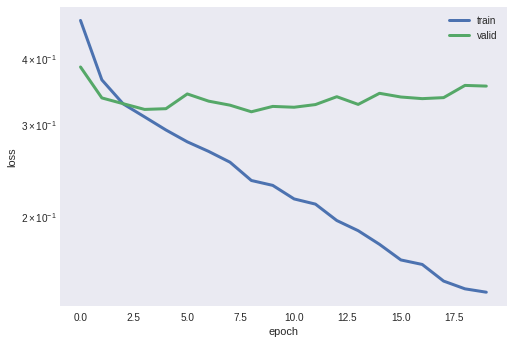

In [28]:
# X = X.toarray()
# X = X.reshape((X.shape[0],X.shape[1],1))

# X_test = X_test.toarray()
# X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

# print(X.shape)
# print(X_test.shape)



model = cnn_modelv4(input_shape=X.shape)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=20)
test_model(model,X_test,y_test)
plot_loss(hist)

#### Another deep CNN

In [0]:
def cnn_modelv5(input_shape):

  from keras.models import Model
  from keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Flatten,AveragePooling1D

  input_layer = Input(shape=(input_shape[1],input_shape[2],))
  x = Conv1D(16, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_layer)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Conv1D(32, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Flatten()(x)
  x = Dropout(0.7)(x)
  x = Dense(500,activation='relu')(x)
  x = Dropout(0.7)(x)
  # x = Dense(128,activation='relu')(x)
  # x = Dropout(0.5)(x)
  output_layer = Dense(2,activation='softmax')(x)
  model = Model(inputs=input_layer, outputs=output_layer)

  model.summary()

  return model
# 32 -> 16 gace 87.14%

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 8000, 1)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 7998, 16)          64        
_________________________________________________________________
average_pooling1d_19 (Averag (None, 2666, 16)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 2664, 32)          1568      
_________________________________________________________________
average_pooling1d_20 (Averag (None, 888, 32)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 28416)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 28416)             0         
__________

20000/20000 [==============================] - 25s 1ms/step - loss: 0.4814 - acc: 0.7796 - val_loss: 0.3912 - val_acc: 0.8372
Epoch 2/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.3791 - acc: 0.8348 - val_loss: 0.3532 - val_acc: 0.8508
Epoch 3/20
 1472/20000 [=>............................] - ETA: 23s - loss: 0.3602 - acc: 0.8431

20000/20000 [==============================] - 24s 1ms/step - loss: 0.3473 - acc: 0.8487 - val_loss: 0.3337 - val_acc: 0.8600
Epoch 4/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.3297 - acc: 0.8577 - val_loss: 0.3312 - val_acc: 0.8608
Epoch 5/20
 1024/20000 [>.............................] - ETA: 23s - loss: 0.3194 - acc: 0.8584

20000/20000 [==============================] - 24s 1ms/step - loss: 0.3161 - acc: 0.8622 - val_loss: 0.3235 - val_acc: 0.8662
Epoch 6/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.3051 - acc: 0.8676 - val_loss: 0.3185 - val_acc: 0.8712
Epoch 7/20
  800/20000 [>.............................] - ETA: 24s - loss: 0.2786 - acc: 0.8825

20000/20000 [==============================] - 24s 1ms/step - loss: 0.2921 - acc: 0.8709 - val_loss: 0.3183 - val_acc: 0.8676
Epoch 8/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.2830 - acc: 0.8804 - val_loss: 0.3155 - val_acc: 0.8668
Epoch 9/20
  704/20000 [>.............................] - ETA: 25s - loss: 0.2654 - acc: 0.8778

20000/20000 [==============================] - 24s 1ms/step - loss: 0.2680 - acc: 0.8854 - val_loss: 0.3163 - val_acc: 0.8646
Epoch 10/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.2659 - acc: 0.8877 - val_loss: 0.3143 - val_acc: 0.8698
Epoch 11/20
  864/20000 [>.............................] - ETA: 24s - loss: 0.2390 - acc: 0.9086

20000/20000 [==============================] - 24s 1ms/step - loss: 0.2541 - acc: 0.8939 - val_loss: 0.3214 - val_acc: 0.8660
Epoch 12/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.2452 - acc: 0.8962 - val_loss: 0.3180 - val_acc: 0.8726
Epoch 13/20
  864/20000 [>.............................] - ETA: 21s - loss: 0.2471 - acc: 0.8947

20000/20000 [==============================] - 24s 1ms/step - loss: 0.2389 - acc: 0.9018 - val_loss: 0.3146 - val_acc: 0.8688
Epoch 14/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.2311 - acc: 0.9061 - val_loss: 0.3165 - val_acc: 0.8702
Epoch 15/20
  928/20000 [>.............................] - ETA: 21s - loss: 0.2233 - acc: 0.9030

20000/20000 [==============================] - 24s 1ms/step - loss: 0.2241 - acc: 0.9072 - val_loss: 0.3188 - val_acc: 0.8668
Epoch 16/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.2160 - acc: 0.9102 - val_loss: 0.3205 - val_acc: 0.8704
Epoch 17/20
  928/20000 [>.............................] - ETA: 21s - loss: 0.1884 - acc: 0.9235

20000/20000 [==============================] - 24s 1ms/step - loss: 0.2038 - acc: 0.9181 - val_loss: 0.3287 - val_acc: 0.8670
Epoch 18/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.2000 - acc: 0.9204 - val_loss: 0.3289 - val_acc: 0.8676
Epoch 19/20
  928/20000 [>.............................] - ETA: 21s - loss: 0.1896 - acc: 0.9149

20000/20000 [==============================] - 24s 1ms/step - loss: 0.1929 - acc: 0.9226 - val_loss: 0.3244 - val_acc: 0.8712
Epoch 20/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.1783 - acc: 0.9276 - val_loss: 0.3301 - val_acc: 0.8748
Testing model on 25000
Test Accuracy: 86.872000


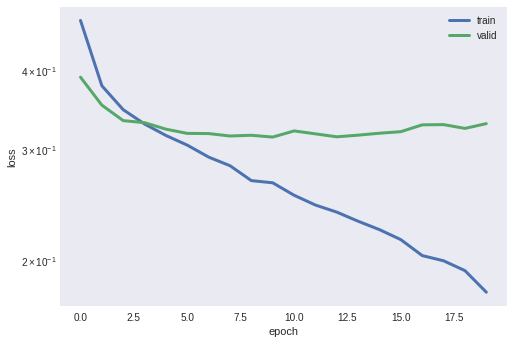

In [26]:
# X = X.toarray()
# X = X.reshape((X.shape[0],X.shape[1],1))

# X_test = X_test.toarray()
# X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

# print(X.shape)
# print(X_test.shape)



model = cnn_modelv5(input_shape=X.shape)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=20)
test_model(model,X_test,y_test)
plot_loss(hist)

#### Deeper CNN

In [0]:
def cnn_modelv6(input_shape):

  from keras.models import Model
  from keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Flatten,AveragePooling1D

  input_layer = Input(shape=(input_shape[1],input_shape[2],))
  x = Conv1D(16, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_layer)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Conv1D(32, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Conv1D(64, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Flatten()(x)
  x = Dropout(0.7)(x)
  x = Dense(500,activation='relu')(x)
  x = Dropout(0.7)(x)
  # x = Dense(128,activation='relu')(x)
  # x = Dropout(0.5)(x)
  output_layer = Dense(2,activation='softmax')(x)
  model = Model(inputs=input_layer, outputs=output_layer)

  model.summary()

  return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 8000, 1)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 7998, 16)          64        
_________________________________________________________________
average_pooling1d_31 (Averag (None, 2666, 16)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 2664, 32)          1568      
_________________________________________________________________
average_pooling1d_32 (Averag (None, 888, 32)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 886, 64)           6208      
_________________________________________________________________
average_pooling1d_33 (Averag (None, 295, 64)           0         
__________

20000/20000 [==============================] - 22s 1ms/step - loss: 0.5512 - acc: 0.7233 - val_loss: 0.4579 - val_acc: 0.7968
Epoch 2/20
20000/20000 [==============================] - 22s 1ms/step - loss: 0.4623 - acc: 0.7847 - val_loss: 0.4101 - val_acc: 0.8098
Epoch 3/20
  864/20000 [>.............................] - ETA: 21s - loss: 0.4241 - acc: 0.8171

20000/20000 [==============================] - 22s 1ms/step - loss: 0.4234 - acc: 0.8053 - val_loss: 0.3844 - val_acc: 0.8268
Epoch 4/20
20000/20000 [==============================] - 22s 1ms/step - loss: 0.3984 - acc: 0.8185 - val_loss: 0.3725 - val_acc: 0.8402


Epoch 5/20
20000/20000 [==============================] - 22s 1ms/step - loss: 0.3799 - acc: 0.8300 - val_loss: 0.3607 - val_acc: 0.8426
Epoch 6/20
17824/20000 [=========================>....] - ETA: 2s - loss: 0.3705 - acc: 0.8349

20000/20000 [==============================] - 22s 1ms/step - loss: 0.3701 - acc: 0.8341 - val_loss: 0.3489 - val_acc: 0.8490
Epoch 7/20
20000/20000 [==============================] - 22s 1ms/step - loss: 0.3566 - acc: 0.8427 - val_loss: 0.3462 - val_acc: 0.8494
Epoch 8/20
 4192/20000 [=====>........................] - ETA: 16s - loss: 0.3458 - acc: 0.8488

20000/20000 [==============================] - 22s 1ms/step - loss: 0.3448 - acc: 0.8488 - val_loss: 0.3470 - val_acc: 0.8490
Epoch 9/20
20000/20000 [==============================] - 22s 1ms/step - loss: 0.3383 - acc: 0.8516 - val_loss: 0.3420 - val_acc: 0.8514
Epoch 10/20
  672/20000 [>.............................] - ETA: 23s - loss: 0.3124 - acc: 0.8765

20000/20000 [==============================] - 22s 1ms/step - loss: 0.3292 - acc: 0.8565 - val_loss: 0.3353 - val_acc: 0.8586
Epoch 11/20
20000/20000 [==============================] - 22s 1ms/step - loss: 0.3251 - acc: 0.8578 - val_loss: 0.3335 - val_acc: 0.8596
Epoch 12/20
   96/20000 [..............................] - ETA: 26s - loss: 0.3117 - acc: 0.8333

20000/20000 [==============================] - 22s 1ms/step - loss: 0.3166 - acc: 0.8612 - val_loss: 0.3349 - val_acc: 0.8562
Epoch 13/20
19648/20000 [============================>.] - ETA: 0s - loss: 0.3109 - acc: 0.8639

20000/20000 [==============================] - 22s 1ms/step - loss: 0.3108 - acc: 0.8640 - val_loss: 0.3329 - val_acc: 0.8568
Epoch 14/20
20000/20000 [==============================] - 22s 1ms/step - loss: 0.3039 - acc: 0.8694 - val_loss: 0.3275 - val_acc: 0.8604
Epoch 15/20
 4128/20000 [=====>........................] - ETA: 17s - loss: 0.2942 - acc: 0.8702

20000/20000 [==============================] - 22s 1ms/step - loss: 0.2986 - acc: 0.8718 - val_loss: 0.3301 - val_acc: 0.8552
Epoch 16/20
20000/20000 [==============================] - 22s 1ms/step - loss: 0.2973 - acc: 0.8706 - val_loss: 0.3276 - val_acc: 0.8606
Epoch 17/20
  928/20000 [>.............................] - ETA: 19s - loss: 0.2637 - acc: 0.8761

20000/20000 [==============================] - 22s 1ms/step - loss: 0.2880 - acc: 0.8759 - val_loss: 0.3257 - val_acc: 0.8594
Epoch 18/20
20000/20000 [==============================] - 22s 1ms/step - loss: 0.2899 - acc: 0.8765 - val_loss: 0.3261 - val_acc: 0.8632
Epoch 19/20
  224/20000 [..............................] - ETA: 20s - loss: 0.2547 - acc: 0.8750

20000/20000 [==============================] - 22s 1ms/step - loss: 0.2757 - acc: 0.8821 - val_loss: 0.3261 - val_acc: 0.8626
Epoch 20/20
19936/20000 [============================>.] - ETA: 0s - loss: 0.2748 - acc: 0.8809

20000/20000 [==============================] - 22s 1ms/step - loss: 0.2746 - acc: 0.8812 - val_loss: 0.3350 - val_acc: 0.8616
Testing model on 25000
Test Accuracy: 86.452000


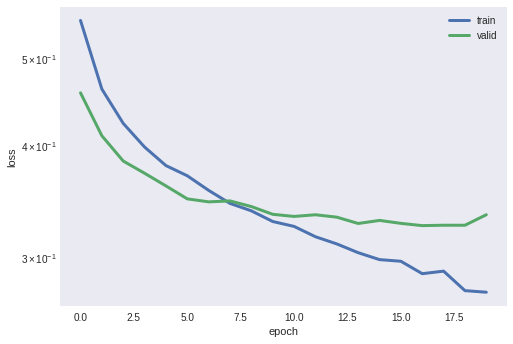

In [32]:
# X = X.toarray()
# X = X.reshape((X.shape[0],X.shape[1],1))

# X_test = X_test.toarray()
# X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

# print(X.shape)
# print(X_test.shape)



model = cnn_modelv6(input_shape=X.shape)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=20)
test_model(model,X_test,y_test)
plot_loss(hist)

### Trying out Fully Convolutional Neural Network

In [0]:
train_file = './data_stopwords/train.data' #floyd
test_file = './data_stopwords/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

print("Tokenizing")
X,X_test = ngram_tokenize(X,X_test,max_features=8000,ngram=(1,1))
print(X.shape)
print(X_test.shape)

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
y = y.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y = enc.fit_transform(y)
y_test = enc.fit_transform(y_test)
# [0->for negative 1-> for positive]

#### Average pooling

In [0]:
def cnn_modelv7(input_shape):

  from keras.models import Model
  from keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Flatten,AveragePooling1D,GlobalAveragePooling1D

  input_layer = Input(shape=(input_shape[1],input_shape[2],))
  x = Conv1D(32, 5, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_layer)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Conv1D(16, 5, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Conv1D(8, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)
 
  x = Conv1D(2, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = AveragePooling1D(pool_size=3, strides=None, padding='valid')(x)
  
  output_layer = GlobalAveragePooling1D()(x)
 
  #output_layer = Dense(2,activation='softmax')(x)
  model = Model(inputs=input_layer, outputs=output_layer)

  model.summary()

  return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 8000, 1)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 7996, 32)          192       
_________________________________________________________________
average_pooling1d_38 (Averag (None, 2665, 32)          0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 2661, 16)          2576      
_________________________________________________________________
average_pooling1d_39 (Averag (None, 887, 16)           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 885, 8)            392       
_________________________________________________________________
average_pooling1d_40 (Averag (None, 295, 8)            0         
__________

20000/20000 [==============================] - 15s 763us/step - loss: 0.6944 - acc: 0.5165 - val_loss: 0.6902 - val_acc: 0.5474
Epoch 2/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6903 - acc: 0.5321 - val_loss: 0.6880 - val_acc: 0.5506
Epoch 3/500
10336/20000 [==============>...............] - ETA: 6s - loss: 0.6884 - acc: 0.5475

20000/20000 [==============================] - 14s 707us/step - loss: 0.6881 - acc: 0.5492 - val_loss: 0.6868 - val_acc: 0.5570
Epoch 4/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.6852 - acc: 0.5556 - val_loss: 0.6856 - val_acc: 0.5700
Epoch 5/500
11360/20000 [================>.............] - ETA: 5s - loss: 0.6858 - acc: 0.5564

20000/20000 [==============================] - 14s 720us/step - loss: 0.6859 - acc: 0.5541 - val_loss: 0.6820 - val_acc: 0.5812
Epoch 6/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.6829 - acc: 0.5679 - val_loss: 0.6796 - val_acc: 0.5780
Epoch 7/500
11584/20000 [================>.............] - ETA: 5s - loss: 0.6791 - acc: 0.5725

20000/20000 [==============================] - 14s 715us/step - loss: 0.6790 - acc: 0.5754 - val_loss: 0.6761 - val_acc: 0.5842
Epoch 8/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.6773 - acc: 0.5802 - val_loss: 0.6813 - val_acc: 0.5836
Epoch 9/500
11744/20000 [================>.............] - ETA: 5s - loss: 0.6754 - acc: 0.5857

20000/20000 [==============================] - 14s 713us/step - loss: 0.6758 - acc: 0.5886 - val_loss: 0.7165 - val_acc: 0.4990
Epoch 10/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.6732 - acc: 0.5895 - val_loss: 0.6705 - val_acc: 0.5960
Epoch 11/500
11840/20000 [================>.............] - ETA: 5s - loss: 0.6645 - acc: 0.6043

20000/20000 [==============================] - 14s 718us/step - loss: 0.6639 - acc: 0.6049 - val_loss: 0.6616 - val_acc: 0.6128
Epoch 12/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.6581 - acc: 0.6133 - val_loss: 0.6560 - val_acc: 0.6236
Epoch 13/500
11744/20000 [================>.............] - ETA: 5s - loss: 0.6568 - acc: 0.6160

20000/20000 [==============================] - 14s 716us/step - loss: 0.6548 - acc: 0.6202 - val_loss: 0.6567 - val_acc: 0.6246
Epoch 14/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.6496 - acc: 0.6241 - val_loss: 0.6516 - val_acc: 0.6246
Epoch 15/500
11872/20000 [================>.............] - ETA: 5s - loss: 0.6421 - acc: 0.6381

20000/20000 [==============================] - 14s 708us/step - loss: 0.6454 - acc: 0.6324 - val_loss: 0.6468 - val_acc: 0.6388
Epoch 16/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6419 - acc: 0.6396 - val_loss: 0.6434 - val_acc: 0.6440
Epoch 17/500
11776/20000 [================>.............] - ETA: 5s - loss: 0.6440 - acc: 0.6388

20000/20000 [==============================] - 14s 716us/step - loss: 0.6417 - acc: 0.6401 - val_loss: 0.6407 - val_acc: 0.6448
Epoch 18/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.6381 - acc: 0.6443 - val_loss: 0.6386 - val_acc: 0.6372
Epoch 19/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6371 - acc: 0.6436

20000/20000 [==============================] - 14s 718us/step - loss: 0.6350 - acc: 0.6428 - val_loss: 0.6459 - val_acc: 0.6322
Epoch 20/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.6337 - acc: 0.6488 - val_loss: 0.6474 - val_acc: 0.6296
Epoch 21/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.6378 - acc: 0.6425

20000/20000 [==============================] - 14s 710us/step - loss: 0.6359 - acc: 0.6474 - val_loss: 0.6433 - val_acc: 0.6342
Epoch 22/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6381 - acc: 0.6418 - val_loss: 0.6349 - val_acc: 0.6444
Epoch 23/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.6413 - acc: 0.6385

20000/20000 [==============================] - 14s 717us/step - loss: 0.6377 - acc: 0.6392 - val_loss: 0.6366 - val_acc: 0.6468
Epoch 24/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6307 - acc: 0.6472 - val_loss: 0.6385 - val_acc: 0.6418
Epoch 25/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.6250 - acc: 0.6574

20000/20000 [==============================] - 14s 715us/step - loss: 0.6278 - acc: 0.6521 - val_loss: 0.6361 - val_acc: 0.6436
Epoch 26/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.6297 - acc: 0.6511 - val_loss: 0.6338 - val_acc: 0.6456
Epoch 27/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.6276 - acc: 0.6530

20000/20000 [==============================] - 14s 715us/step - loss: 0.6276 - acc: 0.6522 - val_loss: 0.6336 - val_acc: 0.6544
Epoch 28/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.6275 - acc: 0.6543 - val_loss: 0.6343 - val_acc: 0.6512
Epoch 29/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.6244 - acc: 0.6554

20000/20000 [==============================] - 14s 716us/step - loss: 0.6250 - acc: 0.6551 - val_loss: 0.6412 - val_acc: 0.6424
Epoch 30/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.6253 - acc: 0.6582 - val_loss: 0.6414 - val_acc: 0.6396
Epoch 31/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.6287 - acc: 0.6474

20000/20000 [==============================] - 14s 716us/step - loss: 0.6256 - acc: 0.6556 - val_loss: 0.6361 - val_acc: 0.6448
Epoch 32/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.6239 - acc: 0.6565 - val_loss: 0.6327 - val_acc: 0.6500
Epoch 33/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.6195 - acc: 0.6625

20000/20000 [==============================] - 14s 717us/step - loss: 0.6220 - acc: 0.6586 - val_loss: 0.6316 - val_acc: 0.6510
Epoch 34/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.6273 - acc: 0.6546 - val_loss: 0.6354 - val_acc: 0.6504
Epoch 35/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.6246 - acc: 0.6523

20000/20000 [==============================] - 14s 715us/step - loss: 0.6230 - acc: 0.6579 - val_loss: 0.6381 - val_acc: 0.6526
Epoch 36/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6223 - acc: 0.6586 - val_loss: 0.6352 - val_acc: 0.6410
Epoch 37/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6224 - acc: 0.6624

20000/20000 [==============================] - 14s 712us/step - loss: 0.6287 - acc: 0.6549 - val_loss: 0.6303 - val_acc: 0.6524
Epoch 38/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.6285 - acc: 0.6548 - val_loss: 0.6370 - val_acc: 0.6538
Epoch 39/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.6249 - acc: 0.6580

20000/20000 [==============================] - 14s 709us/step - loss: 0.6235 - acc: 0.6596 - val_loss: 0.6310 - val_acc: 0.6554
Epoch 40/500
20000/20000 [==============================] - 14s 704us/step - loss: 0.6207 - acc: 0.6634 - val_loss: 0.6303 - val_acc: 0.6504
Epoch 41/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.6188 - acc: 0.6696

20000/20000 [==============================] - 14s 711us/step - loss: 0.6199 - acc: 0.6676 - val_loss: 0.6353 - val_acc: 0.6556
Epoch 42/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6212 - acc: 0.6621 - val_loss: 0.6318 - val_acc: 0.6576
Epoch 43/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.6194 - acc: 0.6650

20000/20000 [==============================] - 14s 716us/step - loss: 0.6190 - acc: 0.6642 - val_loss: 0.6356 - val_acc: 0.6458
Epoch 44/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.6178 - acc: 0.6625 - val_loss: 0.6248 - val_acc: 0.6594
Epoch 45/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6170 - acc: 0.6629

20000/20000 [==============================] - 14s 718us/step - loss: 0.6168 - acc: 0.6625 - val_loss: 0.6233 - val_acc: 0.6578
Epoch 46/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.6150 - acc: 0.6653 - val_loss: 0.6291 - val_acc: 0.6580
Epoch 47/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.6415 - acc: 0.6496

20000/20000 [==============================] - 14s 718us/step - loss: 0.6331 - acc: 0.6538 - val_loss: 0.6307 - val_acc: 0.6624
Epoch 48/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.6217 - acc: 0.6601 - val_loss: 0.6255 - val_acc: 0.6578
Epoch 49/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.6259 - acc: 0.6633

20000/20000 [==============================] - 14s 711us/step - loss: 0.6221 - acc: 0.6666 - val_loss: 0.6382 - val_acc: 0.6568
Epoch 50/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6145 - acc: 0.6678 - val_loss: 0.6238 - val_acc: 0.6582
Epoch 51/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.6160 - acc: 0.6696

20000/20000 [==============================] - 14s 709us/step - loss: 0.6126 - acc: 0.6710 - val_loss: 0.6345 - val_acc: 0.6552
Epoch 52/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.6131 - acc: 0.6687 - val_loss: 0.6236 - val_acc: 0.6630
Epoch 53/500
11808/20000 [================>.............] - ETA: 5s - loss: 0.6112 - acc: 0.6709

20000/20000 [==============================] - 14s 712us/step - loss: 0.6128 - acc: 0.6712 - val_loss: 0.6234 - val_acc: 0.6604
Epoch 54/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.6120 - acc: 0.6696 - val_loss: 0.6238 - val_acc: 0.6636
Epoch 55/500
11840/20000 [================>.............] - ETA: 5s - loss: 0.6147 - acc: 0.6672

20000/20000 [==============================] - 14s 715us/step - loss: 0.6112 - acc: 0.6722 - val_loss: 0.6231 - val_acc: 0.6590
Epoch 56/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.6106 - acc: 0.6702 - val_loss: 0.6747 - val_acc: 0.6414
Epoch 57/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.6126 - acc: 0.6694

20000/20000 [==============================] - 14s 711us/step - loss: 0.6125 - acc: 0.6694 - val_loss: 0.6231 - val_acc: 0.6612
Epoch 58/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.6147 - acc: 0.6676 - val_loss: 0.6291 - val_acc: 0.6588
Epoch 59/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.6200 - acc: 0.6592

20000/20000 [==============================] - 14s 712us/step - loss: 0.6201 - acc: 0.6660 - val_loss: 0.6525 - val_acc: 0.6640
Epoch 60/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6134 - acc: 0.6704 - val_loss: 0.6279 - val_acc: 0.6588
Epoch 61/500
11776/20000 [================>.............] - ETA: 5s - loss: 0.6103 - acc: 0.6692

20000/20000 [==============================] - 14s 713us/step - loss: 0.6100 - acc: 0.6710 - val_loss: 0.6250 - val_acc: 0.6650
Epoch 62/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.6137 - acc: 0.6724 - val_loss: 0.6239 - val_acc: 0.6606
Epoch 63/500
11808/20000 [================>.............] - ETA: 5s - loss: 0.6100 - acc: 0.6687

20000/20000 [==============================] - 14s 711us/step - loss: 0.6104 - acc: 0.6678 - val_loss: 0.6355 - val_acc: 0.6586
Epoch 64/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.6071 - acc: 0.6746 - val_loss: 0.6395 - val_acc: 0.6628
Epoch 65/500
11808/20000 [================>.............] - ETA: 5s - loss: 0.6055 - acc: 0.6780

20000/20000 [==============================] - 14s 711us/step - loss: 0.6086 - acc: 0.6745 - val_loss: 0.6205 - val_acc: 0.6634
Epoch 66/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.6090 - acc: 0.6755 - val_loss: 0.6351 - val_acc: 0.6430
Epoch 67/500
11776/20000 [================>.............] - ETA: 5s - loss: 0.6092 - acc: 0.6753

20000/20000 [==============================] - 14s 710us/step - loss: 0.6181 - acc: 0.6651 - val_loss: 0.6711 - val_acc: 0.5878
Epoch 68/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.6244 - acc: 0.6594 - val_loss: 0.6290 - val_acc: 0.6612
Epoch 69/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.6081 - acc: 0.6789

20000/20000 [==============================] - 14s 712us/step - loss: 0.6078 - acc: 0.6772 - val_loss: 0.6249 - val_acc: 0.6600
Epoch 70/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6070 - acc: 0.6751 - val_loss: 0.6407 - val_acc: 0.6584
Epoch 71/500
11936/20000 [================>.............] - ETA: 5s - loss: 0.6068 - acc: 0.6771

20000/20000 [==============================] - 14s 709us/step - loss: 0.6071 - acc: 0.6758 - val_loss: 0.6251 - val_acc: 0.6568
Epoch 72/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.6090 - acc: 0.6771 - val_loss: 0.6282 - val_acc: 0.6578
Epoch 73/500
11904/20000 [================>.............] - ETA: 5s - loss: 0.6048 - acc: 0.6798

20000/20000 [==============================] - 14s 710us/step - loss: 0.6058 - acc: 0.6785 - val_loss: 0.6354 - val_acc: 0.6594
Epoch 74/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.6096 - acc: 0.6754 - val_loss: 0.6303 - val_acc: 0.6592
Epoch 75/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6075 - acc: 0.6745

20000/20000 [==============================] - 14s 715us/step - loss: 0.6178 - acc: 0.6643 - val_loss: 0.6310 - val_acc: 0.6586
Epoch 76/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.6142 - acc: 0.6704 - val_loss: 0.6215 - val_acc: 0.6634
Epoch 77/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.6060 - acc: 0.6697

20000/20000 [==============================] - 14s 714us/step - loss: 0.6095 - acc: 0.6709 - val_loss: 0.6168 - val_acc: 0.6660
Epoch 78/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6092 - acc: 0.6748 - val_loss: 0.6193 - val_acc: 0.6618
Epoch 79/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.6058 - acc: 0.6822

20000/20000 [==============================] - 14s 712us/step - loss: 0.6086 - acc: 0.6762 - val_loss: 0.6234 - val_acc: 0.6636
Epoch 80/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6047 - acc: 0.6782 - val_loss: 0.6215 - val_acc: 0.6668
Epoch 81/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.6071 - acc: 0.6790

20000/20000 [==============================] - 14s 711us/step - loss: 0.6046 - acc: 0.6805 - val_loss: 0.6196 - val_acc: 0.6698
Epoch 82/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6046 - acc: 0.6765 - val_loss: 0.6290 - val_acc: 0.6600
Epoch 83/500
11744/20000 [================>.............] - ETA: 5s - loss: 0.6111 - acc: 0.6722

20000/20000 [==============================] - 14s 712us/step - loss: 0.6070 - acc: 0.6785 - val_loss: 0.6260 - val_acc: 0.6684
Epoch 84/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.6035 - acc: 0.6779 - val_loss: 0.6211 - val_acc: 0.6684
Epoch 85/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6318 - acc: 0.6520

20000/20000 [==============================] - 14s 710us/step - loss: 0.6352 - acc: 0.6452 - val_loss: 0.6315 - val_acc: 0.6506
Epoch 86/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.6193 - acc: 0.6621 - val_loss: 0.6257 - val_acc: 0.6610
Epoch 87/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6181 - acc: 0.6688

20000/20000 [==============================] - 14s 713us/step - loss: 0.6160 - acc: 0.6713 - val_loss: 0.6297 - val_acc: 0.6644
Epoch 88/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.6107 - acc: 0.6763 - val_loss: 0.6289 - val_acc: 0.6638
Epoch 89/500
11744/20000 [================>.............] - ETA: 5s - loss: 0.6052 - acc: 0.6842

20000/20000 [==============================] - 14s 712us/step - loss: 0.6082 - acc: 0.6782 - val_loss: 0.6250 - val_acc: 0.6632
Epoch 90/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6074 - acc: 0.6779 - val_loss: 0.6198 - val_acc: 0.6656
Epoch 91/500
11488/20000 [================>.............] - ETA: 5s - loss: 0.6264 - acc: 0.6566

20000/20000 [==============================] - 14s 714us/step - loss: 0.6223 - acc: 0.6592 - val_loss: 0.6257 - val_acc: 0.6636
Epoch 92/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6102 - acc: 0.6728 - val_loss: 0.6207 - val_acc: 0.6614
Epoch 93/500
11584/20000 [================>.............] - ETA: 5s - loss: 0.6094 - acc: 0.6769

20000/20000 [==============================] - 14s 715us/step - loss: 0.6107 - acc: 0.6791 - val_loss: 0.6183 - val_acc: 0.6652
Epoch 94/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.6074 - acc: 0.6797 - val_loss: 0.6237 - val_acc: 0.6644
Epoch 95/500
11744/20000 [================>.............] - ETA: 5s - loss: 0.6054 - acc: 0.6771

20000/20000 [==============================] - 14s 711us/step - loss: 0.6042 - acc: 0.6806 - val_loss: 0.6211 - val_acc: 0.6672
Epoch 96/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.6069 - acc: 0.6816 - val_loss: 0.6442 - val_acc: 0.6588
Epoch 97/500
11744/20000 [================>.............] - ETA: 5s - loss: 0.6035 - acc: 0.6824

20000/20000 [==============================] - 14s 715us/step - loss: 0.6058 - acc: 0.6795 - val_loss: 0.6283 - val_acc: 0.6658
Epoch 98/500
20000/20000 [==============================] - 14s 711us/step - loss: 0.6105 - acc: 0.6771 - val_loss: 0.6270 - val_acc: 0.6638
Epoch 99/500
11840/20000 [================>.............] - ETA: 5s - loss: 0.6100 - acc: 0.6735

20000/20000 [==============================] - 14s 708us/step - loss: 0.6098 - acc: 0.6764 - val_loss: 0.6335 - val_acc: 0.6610
Epoch 100/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6072 - acc: 0.6806 - val_loss: 0.6252 - val_acc: 0.6642
Epoch 101/500
11488/20000 [================>.............] - ETA: 5s - loss: 0.6068 - acc: 0.6775

20000/20000 [==============================] - 14s 709us/step - loss: 0.6058 - acc: 0.6784 - val_loss: 0.6206 - val_acc: 0.6696
Epoch 102/500
20000/20000 [==============================] - 14s 709us/step - loss: 0.6766 - acc: 0.6103 - val_loss: 0.6690 - val_acc: 0.6170
Epoch 103/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6629 - acc: 0.6241

20000/20000 [==============================] - 14s 707us/step - loss: 0.6579 - acc: 0.6321 - val_loss: 0.6494 - val_acc: 0.6406
Epoch 104/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6373 - acc: 0.6526 - val_loss: 0.6392 - val_acc: 0.6330
Epoch 105/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.6290 - acc: 0.6633

20000/20000 [==============================] - 14s 712us/step - loss: 0.6239 - acc: 0.6649 - val_loss: 0.6248 - val_acc: 0.6574
Epoch 106/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.6146 - acc: 0.6724 - val_loss: 0.6200 - val_acc: 0.6592
Epoch 107/500
11488/20000 [================>.............] - ETA: 5s - loss: 0.6107 - acc: 0.6764

20000/20000 [==============================] - 14s 711us/step - loss: 0.6091 - acc: 0.6780 - val_loss: 0.6170 - val_acc: 0.6670
Epoch 108/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.6075 - acc: 0.6765 - val_loss: 0.6266 - val_acc: 0.6652
Epoch 109/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6036 - acc: 0.6793

20000/20000 [==============================] - 14s 712us/step - loss: 0.6054 - acc: 0.6781 - val_loss: 0.6157 - val_acc: 0.6640
Epoch 110/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.6037 - acc: 0.6798 - val_loss: 0.6134 - val_acc: 0.6706
Epoch 111/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.6004 - acc: 0.6790

20000/20000 [==============================] - 14s 715us/step - loss: 0.6029 - acc: 0.6794 - val_loss: 0.6186 - val_acc: 0.6668
Epoch 112/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6031 - acc: 0.6821 - val_loss: 0.6288 - val_acc: 0.6542
Epoch 113/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6081 - acc: 0.6755

20000/20000 [==============================] - 14s 718us/step - loss: 0.6060 - acc: 0.6763 - val_loss: 0.6284 - val_acc: 0.6564
Epoch 114/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6038 - acc: 0.6832 - val_loss: 0.6356 - val_acc: 0.6474
Epoch 115/500
11744/20000 [================>.............] - ETA: 5s - loss: 0.6060 - acc: 0.6761

20000/20000 [==============================] - 14s 702us/step - loss: 0.6022 - acc: 0.6803 - val_loss: 0.6218 - val_acc: 0.6560
Epoch 116/500
20000/20000 [==============================] - 14s 711us/step - loss: 0.6038 - acc: 0.6800 - val_loss: 0.6163 - val_acc: 0.6670
Epoch 117/500
11488/20000 [================>.............] - ETA: 5s - loss: 0.6054 - acc: 0.6758

20000/20000 [==============================] - 14s 714us/step - loss: 0.6033 - acc: 0.6828 - val_loss: 0.6185 - val_acc: 0.6728
Epoch 118/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.6005 - acc: 0.6855 - val_loss: 0.6171 - val_acc: 0.6732
Epoch 119/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.6145 - acc: 0.6840

20000/20000 [==============================] - 14s 715us/step - loss: 0.6104 - acc: 0.6808 - val_loss: 0.6355 - val_acc: 0.6542
Epoch 120/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.6024 - acc: 0.6855 - val_loss: 0.6151 - val_acc: 0.6722
Epoch 121/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5993 - acc: 0.6843

20000/20000 [==============================] - 14s 715us/step - loss: 0.6017 - acc: 0.6832 - val_loss: 0.6410 - val_acc: 0.6324
Epoch 122/500
20000/20000 [==============================] - 14s 711us/step - loss: 0.6009 - acc: 0.6811 - val_loss: 0.6207 - val_acc: 0.6750
Epoch 123/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5979 - acc: 0.6847

20000/20000 [==============================] - 14s 715us/step - loss: 0.6042 - acc: 0.6812 - val_loss: 0.6213 - val_acc: 0.6730
Epoch 124/500
20000/20000 [==============================] - 14s 711us/step - loss: 0.6060 - acc: 0.6815 - val_loss: 0.6159 - val_acc: 0.6768
Epoch 125/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.6005 - acc: 0.6808

20000/20000 [==============================] - 14s 712us/step - loss: 0.6010 - acc: 0.6828 - val_loss: 0.6226 - val_acc: 0.6690
Epoch 126/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6010 - acc: 0.6836 - val_loss: 0.6176 - val_acc: 0.6688
Epoch 127/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6024 - acc: 0.6831

20000/20000 [==============================] - 14s 709us/step - loss: 0.6000 - acc: 0.6842 - val_loss: 0.6145 - val_acc: 0.6804
Epoch 128/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6044 - acc: 0.6778 - val_loss: 0.6285 - val_acc: 0.6576
Epoch 129/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.6101 - acc: 0.6733

20000/20000 [==============================] - 14s 708us/step - loss: 0.6033 - acc: 0.6824 - val_loss: 0.6343 - val_acc: 0.6708
Epoch 130/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5983 - acc: 0.6865 - val_loss: 0.6117 - val_acc: 0.6758
Epoch 131/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.5959 - acc: 0.6891

20000/20000 [==============================] - 14s 714us/step - loss: 0.5997 - acc: 0.6833 - val_loss: 0.6209 - val_acc: 0.6674
Epoch 132/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5976 - acc: 0.6834 - val_loss: 0.6116 - val_acc: 0.6708
Epoch 133/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.5973 - acc: 0.6878

20000/20000 [==============================] - 14s 712us/step - loss: 0.5973 - acc: 0.6875 - val_loss: 0.6272 - val_acc: 0.6586
Epoch 134/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.6019 - acc: 0.6839 - val_loss: 0.6127 - val_acc: 0.6754
Epoch 135/500
11360/20000 [================>.............] - ETA: 5s - loss: 0.5987 - acc: 0.6900

20000/20000 [==============================] - 14s 711us/step - loss: 0.5995 - acc: 0.6884 - val_loss: 0.6164 - val_acc: 0.6708
Epoch 136/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5981 - acc: 0.6860 - val_loss: 0.6143 - val_acc: 0.6790
Epoch 137/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6086 - acc: 0.6738

20000/20000 [==============================] - 14s 706us/step - loss: 0.6046 - acc: 0.6801 - val_loss: 0.6268 - val_acc: 0.6712
Epoch 138/500
20000/20000 [==============================] - 14s 706us/step - loss: 0.5987 - acc: 0.6850 - val_loss: 0.6246 - val_acc: 0.6590
Epoch 139/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5968 - acc: 0.6867

20000/20000 [==============================] - 14s 709us/step - loss: 0.5948 - acc: 0.6891 - val_loss: 0.6124 - val_acc: 0.6724
Epoch 140/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5965 - acc: 0.6895 - val_loss: 0.6243 - val_acc: 0.6774
Epoch 141/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.5973 - acc: 0.6891

20000/20000 [==============================] - 14s 712us/step - loss: 0.5966 - acc: 0.6904 - val_loss: 0.6092 - val_acc: 0.6770
Epoch 142/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.5983 - acc: 0.6875 - val_loss: 0.6418 - val_acc: 0.6470
Epoch 143/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5942 - acc: 0.6914

20000/20000 [==============================] - 14s 715us/step - loss: 0.5950 - acc: 0.6902 - val_loss: 0.6198 - val_acc: 0.6740
Epoch 144/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5952 - acc: 0.6912 - val_loss: 0.6219 - val_acc: 0.6704
Epoch 145/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5965 - acc: 0.6879

20000/20000 [==============================] - 14s 714us/step - loss: 0.5928 - acc: 0.6893 - val_loss: 0.6246 - val_acc: 0.6672
Epoch 146/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5949 - acc: 0.6883 - val_loss: 0.6170 - val_acc: 0.6704
Epoch 147/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5931 - acc: 0.6911

20000/20000 [==============================] - 14s 709us/step - loss: 0.5933 - acc: 0.6898 - val_loss: 0.6094 - val_acc: 0.6768
Epoch 148/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5959 - acc: 0.6871 - val_loss: 0.6265 - val_acc: 0.6734
Epoch 149/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5942 - acc: 0.6947

20000/20000 [==============================] - 14s 714us/step - loss: 0.5959 - acc: 0.6899 - val_loss: 0.6144 - val_acc: 0.6742
Epoch 150/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5927 - acc: 0.6904 - val_loss: 0.6238 - val_acc: 0.6710
Epoch 151/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.6313 - acc: 0.6449

20000/20000 [==============================] - 14s 714us/step - loss: 0.6201 - acc: 0.6596 - val_loss: 0.6229 - val_acc: 0.6548
Epoch 152/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.6096 - acc: 0.6702 - val_loss: 0.6557 - val_acc: 0.6322
Epoch 153/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.6454 - acc: 0.6424

20000/20000 [==============================] - 14s 714us/step - loss: 0.6393 - acc: 0.6486 - val_loss: 0.6403 - val_acc: 0.6492
Epoch 154/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.6255 - acc: 0.6610 - val_loss: 0.6316 - val_acc: 0.6498
Epoch 155/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.6124 - acc: 0.6752

20000/20000 [==============================] - 14s 713us/step - loss: 0.6118 - acc: 0.6745 - val_loss: 0.6190 - val_acc: 0.6686
Epoch 156/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.6033 - acc: 0.6789 - val_loss: 0.6154 - val_acc: 0.6632
Epoch 157/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.6002 - acc: 0.6870

20000/20000 [==============================] - 14s 710us/step - loss: 0.6007 - acc: 0.6837 - val_loss: 0.6184 - val_acc: 0.6670
Epoch 158/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.5973 - acc: 0.6849 - val_loss: 0.6154 - val_acc: 0.6712
Epoch 159/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5962 - acc: 0.6843

20000/20000 [==============================] - 14s 715us/step - loss: 0.5963 - acc: 0.6841 - val_loss: 0.6187 - val_acc: 0.6728
Epoch 160/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5958 - acc: 0.6880 - val_loss: 0.6102 - val_acc: 0.6762
Epoch 161/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5969 - acc: 0.6892

20000/20000 [==============================] - 14s 713us/step - loss: 0.5985 - acc: 0.6886 - val_loss: 0.6095 - val_acc: 0.6754
Epoch 162/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.5972 - acc: 0.6852 - val_loss: 0.6147 - val_acc: 0.6774
Epoch 163/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5931 - acc: 0.6970

20000/20000 [==============================] - 14s 716us/step - loss: 0.5942 - acc: 0.6915 - val_loss: 0.6135 - val_acc: 0.6774
Epoch 164/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5951 - acc: 0.6857 - val_loss: 0.6106 - val_acc: 0.6766
Epoch 165/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5927 - acc: 0.6939

20000/20000 [==============================] - 14s 714us/step - loss: 0.5949 - acc: 0.6918 - val_loss: 0.6144 - val_acc: 0.6740
Epoch 166/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.6026 - acc: 0.6838 - val_loss: 0.6294 - val_acc: 0.6596
Epoch 167/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.6022 - acc: 0.6824

20000/20000 [==============================] - 14s 710us/step - loss: 0.5968 - acc: 0.6874 - val_loss: 0.6161 - val_acc: 0.6754
Epoch 168/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.6026 - acc: 0.6827 - val_loss: 0.6113 - val_acc: 0.6708
Epoch 169/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.6056 - acc: 0.6736

20000/20000 [==============================] - 14s 714us/step - loss: 0.6003 - acc: 0.6788 - val_loss: 0.6120 - val_acc: 0.6710
Epoch 170/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.6061 - acc: 0.6757 - val_loss: 0.6161 - val_acc: 0.6768
Epoch 171/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6066 - acc: 0.6779

20000/20000 [==============================] - 14s 718us/step - loss: 0.6017 - acc: 0.6821 - val_loss: 0.6059 - val_acc: 0.6804
Epoch 172/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5969 - acc: 0.6882 - val_loss: 0.6110 - val_acc: 0.6710
Epoch 173/500
11488/20000 [================>.............] - ETA: 5s - loss: 0.5925 - acc: 0.6952

20000/20000 [==============================] - 14s 712us/step - loss: 0.5931 - acc: 0.6911 - val_loss: 0.6107 - val_acc: 0.6800
Epoch 174/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5946 - acc: 0.6934 - val_loss: 0.6137 - val_acc: 0.6786
Epoch 175/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.5947 - acc: 0.6889

20000/20000 [==============================] - 14s 714us/step - loss: 0.5936 - acc: 0.6898 - val_loss: 0.6214 - val_acc: 0.6764
Epoch 176/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.5938 - acc: 0.6883 - val_loss: 0.6128 - val_acc: 0.6706
Epoch 177/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.5912 - acc: 0.6899

20000/20000 [==============================] - 14s 708us/step - loss: 0.5911 - acc: 0.6909 - val_loss: 0.6124 - val_acc: 0.6792
Epoch 178/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5934 - acc: 0.6897 - val_loss: 0.6154 - val_acc: 0.6776
Epoch 179/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5935 - acc: 0.6905

20000/20000 [==============================] - 14s 711us/step - loss: 0.5936 - acc: 0.6905 - val_loss: 0.6094 - val_acc: 0.6818
Epoch 180/500
20000/20000 [==============================] - 14s 711us/step - loss: 0.5926 - acc: 0.6882 - val_loss: 0.6117 - val_acc: 0.6770
Epoch 181/500
11584/20000 [================>.............] - ETA: 5s - loss: 0.5971 - acc: 0.6902

20000/20000 [==============================] - 14s 710us/step - loss: 0.5955 - acc: 0.6914 - val_loss: 0.6162 - val_acc: 0.6714
Epoch 182/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5963 - acc: 0.6911 - val_loss: 0.6160 - val_acc: 0.6738
Epoch 183/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5982 - acc: 0.6892

20000/20000 [==============================] - 14s 712us/step - loss: 0.5983 - acc: 0.6920 - val_loss: 0.6183 - val_acc: 0.6768
Epoch 184/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5924 - acc: 0.6942 - val_loss: 0.6214 - val_acc: 0.6670
Epoch 185/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5932 - acc: 0.6962

20000/20000 [==============================] - 14s 720us/step - loss: 0.5945 - acc: 0.6931 - val_loss: 0.6132 - val_acc: 0.6772
Epoch 186/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.5931 - acc: 0.6954 - val_loss: 0.6141 - val_acc: 0.6738
Epoch 187/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5955 - acc: 0.6877

20000/20000 [==============================] - 14s 711us/step - loss: 0.5999 - acc: 0.6879 - val_loss: 0.6166 - val_acc: 0.6630
Epoch 188/500
20000/20000 [==============================] - 14s 707us/step - loss: 0.6036 - acc: 0.6818 - val_loss: 0.6138 - val_acc: 0.6710
Epoch 189/500
11488/20000 [================>.............] - ETA: 5s - loss: 0.5919 - acc: 0.6916

20000/20000 [==============================] - 14s 709us/step - loss: 0.5929 - acc: 0.6917 - val_loss: 0.6222 - val_acc: 0.6592
Epoch 190/500
20000/20000 [==============================] - 14s 707us/step - loss: 0.6314 - acc: 0.6517 - val_loss: 0.6372 - val_acc: 0.6520
Epoch 191/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.6138 - acc: 0.6782

20000/20000 [==============================] - 14s 711us/step - loss: 0.6068 - acc: 0.6835 - val_loss: 0.6185 - val_acc: 0.6722
Epoch 192/500
20000/20000 [==============================] - 14s 707us/step - loss: 0.5947 - acc: 0.6894 - val_loss: 0.6138 - val_acc: 0.6752
Epoch 193/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.5928 - acc: 0.6949

20000/20000 [==============================] - 14s 715us/step - loss: 0.5934 - acc: 0.6916 - val_loss: 0.6162 - val_acc: 0.6760
Epoch 194/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.5919 - acc: 0.6956 - val_loss: 0.6285 - val_acc: 0.6740
Epoch 195/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5957 - acc: 0.6878

20000/20000 [==============================] - 14s 715us/step - loss: 0.5959 - acc: 0.6896 - val_loss: 0.6139 - val_acc: 0.6768
Epoch 196/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5896 - acc: 0.6972 - val_loss: 0.6254 - val_acc: 0.6596
Epoch 197/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5952 - acc: 0.6897

20000/20000 [==============================] - 14s 709us/step - loss: 0.5907 - acc: 0.6945 - val_loss: 0.6113 - val_acc: 0.6760
Epoch 198/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.5908 - acc: 0.6959 - val_loss: 0.6207 - val_acc: 0.6734
Epoch 199/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5918 - acc: 0.6911

20000/20000 [==============================] - 14s 710us/step - loss: 0.5913 - acc: 0.6920 - val_loss: 0.6223 - val_acc: 0.6700
Epoch 200/500
20000/20000 [==============================] - 14s 709us/step - loss: 0.5900 - acc: 0.6946 - val_loss: 0.6138 - val_acc: 0.6706
Epoch 201/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5903 - acc: 0.6939

20000/20000 [==============================] - 14s 716us/step - loss: 0.5909 - acc: 0.6932 - val_loss: 0.6169 - val_acc: 0.6736
Epoch 202/500
20000/20000 [==============================] - 14s 709us/step - loss: 0.5954 - acc: 0.6908 - val_loss: 0.6123 - val_acc: 0.6772
Epoch 203/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.5930 - acc: 0.6862

20000/20000 [==============================] - 14s 708us/step - loss: 0.5891 - acc: 0.6904 - val_loss: 0.6362 - val_acc: 0.6644
Epoch 204/500
20000/20000 [==============================] - 14s 711us/step - loss: 0.5909 - acc: 0.6954 - val_loss: 0.6198 - val_acc: 0.6756
Epoch 205/500
11488/20000 [================>.............] - ETA: 5s - loss: 0.5909 - acc: 0.6911

20000/20000 [==============================] - 14s 715us/step - loss: 0.5903 - acc: 0.6958 - val_loss: 0.6182 - val_acc: 0.6700
Epoch 206/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5898 - acc: 0.6905 - val_loss: 0.6138 - val_acc: 0.6728
Epoch 207/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.5945 - acc: 0.6898

20000/20000 [==============================] - 14s 716us/step - loss: 0.5916 - acc: 0.6947 - val_loss: 0.6138 - val_acc: 0.6732
Epoch 208/500
20000/20000 [==============================] - 14s 721us/step - loss: 0.5907 - acc: 0.6939 - val_loss: 0.6204 - val_acc: 0.6776
Epoch 209/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5890 - acc: 0.7010

20000/20000 [==============================] - 14s 711us/step - loss: 0.5916 - acc: 0.6954 - val_loss: 0.6208 - val_acc: 0.6742
Epoch 210/500
20000/20000 [==============================] - 14s 711us/step - loss: 0.5887 - acc: 0.6950 - val_loss: 0.6122 - val_acc: 0.6720
Epoch 211/500
11744/20000 [================>.............] - ETA: 5s - loss: 0.5885 - acc: 0.6986

20000/20000 [==============================] - 14s 708us/step - loss: 0.5888 - acc: 0.6976 - val_loss: 0.6117 - val_acc: 0.6736
Epoch 212/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5922 - acc: 0.6924 - val_loss: 0.6185 - val_acc: 0.6774
Epoch 213/500
11584/20000 [================>.............] - ETA: 5s - loss: 0.5831 - acc: 0.6999

20000/20000 [==============================] - 14s 716us/step - loss: 0.5907 - acc: 0.6942 - val_loss: 0.6326 - val_acc: 0.6658
Epoch 214/500
20000/20000 [==============================] - 14s 721us/step - loss: 0.5910 - acc: 0.6966 - val_loss: 0.6213 - val_acc: 0.6786
Epoch 215/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5978 - acc: 0.6856

20000/20000 [==============================] - 14s 719us/step - loss: 0.5941 - acc: 0.6906 - val_loss: 0.6099 - val_acc: 0.6834
Epoch 216/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5897 - acc: 0.6941 - val_loss: 0.6186 - val_acc: 0.6792
Epoch 217/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5840 - acc: 0.7009

20000/20000 [==============================] - 14s 719us/step - loss: 0.5874 - acc: 0.6978 - val_loss: 0.6095 - val_acc: 0.6842
Epoch 218/500
20000/20000 [==============================] - 14s 721us/step - loss: 0.5877 - acc: 0.6970 - val_loss: 0.6093 - val_acc: 0.6830
Epoch 219/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5865 - acc: 0.6971

20000/20000 [==============================] - 14s 719us/step - loss: 0.5953 - acc: 0.6935 - val_loss: 0.6092 - val_acc: 0.6772
Epoch 220/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5945 - acc: 0.6941 - val_loss: 0.6108 - val_acc: 0.6728
Epoch 221/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5837 - acc: 0.7014

20000/20000 [==============================] - 14s 716us/step - loss: 0.5870 - acc: 0.6987 - val_loss: 0.6137 - val_acc: 0.6746
Epoch 222/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.5873 - acc: 0.6991 - val_loss: 0.6111 - val_acc: 0.6806
Epoch 223/500
11360/20000 [================>.............] - ETA: 5s - loss: 0.5952 - acc: 0.6946

20000/20000 [==============================] - 14s 710us/step - loss: 0.5924 - acc: 0.6956 - val_loss: 0.6114 - val_acc: 0.6776
Epoch 224/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5898 - acc: 0.6939 - val_loss: 0.6128 - val_acc: 0.6710
Epoch 225/500
11296/20000 [===============>..............] - ETA: 5s - loss: 0.5906 - acc: 0.6992

20000/20000 [==============================] - 14s 716us/step - loss: 0.5898 - acc: 0.6956 - val_loss: 0.6169 - val_acc: 0.6788
Epoch 226/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5900 - acc: 0.6956 - val_loss: 0.6214 - val_acc: 0.6752
Epoch 227/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.5888 - acc: 0.7008

20000/20000 [==============================] - 14s 713us/step - loss: 0.5883 - acc: 0.6986 - val_loss: 0.6162 - val_acc: 0.6764
Epoch 228/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5879 - acc: 0.6956 - val_loss: 0.6312 - val_acc: 0.6694
Epoch 229/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5858 - acc: 0.6962

20000/20000 [==============================] - 14s 708us/step - loss: 0.5863 - acc: 0.6977 - val_loss: 0.6109 - val_acc: 0.6812
Epoch 230/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.5870 - acc: 0.6974 - val_loss: 0.6295 - val_acc: 0.6770
Epoch 231/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5844 - acc: 0.7029

20000/20000 [==============================] - 14s 716us/step - loss: 0.5875 - acc: 0.6984 - val_loss: 0.6117 - val_acc: 0.6816
Epoch 232/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5883 - acc: 0.6988 - val_loss: 0.6134 - val_acc: 0.6812
Epoch 233/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5874 - acc: 0.6952

20000/20000 [==============================] - 14s 710us/step - loss: 0.5868 - acc: 0.6959 - val_loss: 0.6118 - val_acc: 0.6818
Epoch 234/500
20000/20000 [==============================] - 14s 706us/step - loss: 0.5890 - acc: 0.6987 - val_loss: 0.6166 - val_acc: 0.6838
Epoch 235/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5880 - acc: 0.6952

20000/20000 [==============================] - 14s 719us/step - loss: 0.5898 - acc: 0.6954 - val_loss: 0.6320 - val_acc: 0.6716
Epoch 236/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5870 - acc: 0.6987 - val_loss: 0.6163 - val_acc: 0.6774
Epoch 237/500
11360/20000 [================>.............] - ETA: 5s - loss: 0.5812 - acc: 0.7028

20000/20000 [==============================] - 14s 717us/step - loss: 0.5887 - acc: 0.6966 - val_loss: 0.6107 - val_acc: 0.6786
Epoch 238/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5851 - acc: 0.6953 - val_loss: 0.6188 - val_acc: 0.6776
Epoch 239/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.5862 - acc: 0.6992

20000/20000 [==============================] - 14s 721us/step - loss: 0.5879 - acc: 0.6977 - val_loss: 0.6164 - val_acc: 0.6792
Epoch 240/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5865 - acc: 0.6988 - val_loss: 0.6232 - val_acc: 0.6728
Epoch 241/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5901 - acc: 0.6976

20000/20000 [==============================] - 14s 712us/step - loss: 0.5888 - acc: 0.6997 - val_loss: 0.6202 - val_acc: 0.6768
Epoch 242/500
20000/20000 [==============================] - 14s 698us/step - loss: 0.5866 - acc: 0.6976 - val_loss: 0.6252 - val_acc: 0.6746
Epoch 243/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5839 - acc: 0.7006

20000/20000 [==============================] - 14s 697us/step - loss: 0.5865 - acc: 0.6982 - val_loss: 0.6533 - val_acc: 0.6702
Epoch 244/500
20000/20000 [==============================] - 14s 697us/step - loss: 0.5961 - acc: 0.6918 - val_loss: 0.6134 - val_acc: 0.6768
Epoch 245/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5844 - acc: 0.6976

20000/20000 [==============================] - 14s 700us/step - loss: 0.5876 - acc: 0.6995 - val_loss: 0.6128 - val_acc: 0.6758
Epoch 246/500
20000/20000 [==============================] - 14s 703us/step - loss: 0.5910 - acc: 0.6979 - val_loss: 0.6169 - val_acc: 0.6778
Epoch 247/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5887 - acc: 0.6994

20000/20000 [==============================] - 14s 706us/step - loss: 0.5855 - acc: 0.6988 - val_loss: 0.6136 - val_acc: 0.6886
Epoch 248/500
20000/20000 [==============================] - 14s 705us/step - loss: 0.5878 - acc: 0.7000 - val_loss: 0.6158 - val_acc: 0.6814
Epoch 249/500
11744/20000 [================>.............] - ETA: 5s - loss: 0.5793 - acc: 0.7047

20000/20000 [==============================] - 14s 703us/step - loss: 0.5848 - acc: 0.6999 - val_loss: 0.6128 - val_acc: 0.6792
Epoch 250/500
20000/20000 [==============================] - 14s 704us/step - loss: 0.5859 - acc: 0.7000 - val_loss: 0.6152 - val_acc: 0.6790
Epoch 251/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5779 - acc: 0.7041

20000/20000 [==============================] - 14s 702us/step - loss: 0.5883 - acc: 0.6944 - val_loss: 0.6153 - val_acc: 0.6812
Epoch 252/500
20000/20000 [==============================] - 14s 709us/step - loss: 0.5857 - acc: 0.7019 - val_loss: 0.6093 - val_acc: 0.6856
Epoch 253/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5826 - acc: 0.7004

20000/20000 [==============================] - 14s 703us/step - loss: 0.5850 - acc: 0.6987 - val_loss: 0.6174 - val_acc: 0.6786
Epoch 254/500
20000/20000 [==============================] - 14s 705us/step - loss: 0.5993 - acc: 0.6863 - val_loss: 0.6349 - val_acc: 0.6440
Epoch 255/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.6171 - acc: 0.6722

20000/20000 [==============================] - 14s 704us/step - loss: 0.6094 - acc: 0.6779 - val_loss: 0.6129 - val_acc: 0.6744
Epoch 256/500
20000/20000 [==============================] - 14s 705us/step - loss: 0.5919 - acc: 0.6934 - val_loss: 0.6202 - val_acc: 0.6786
Epoch 257/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5843 - acc: 0.6957

20000/20000 [==============================] - 14s 706us/step - loss: 0.5875 - acc: 0.6961 - val_loss: 0.6223 - val_acc: 0.6796
Epoch 258/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.5861 - acc: 0.6996 - val_loss: 0.6102 - val_acc: 0.6818
Epoch 259/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5838 - acc: 0.7007

20000/20000 [==============================] - 14s 705us/step - loss: 0.5846 - acc: 0.6999 - val_loss: 0.6194 - val_acc: 0.6808
Epoch 260/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.5841 - acc: 0.7033 - val_loss: 0.6132 - val_acc: 0.6844
Epoch 261/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5824 - acc: 0.7034

20000/20000 [==============================] - 14s 710us/step - loss: 0.5840 - acc: 0.6998 - val_loss: 0.6153 - val_acc: 0.6834
Epoch 262/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.5842 - acc: 0.7011 - val_loss: 0.6190 - val_acc: 0.6842
Epoch 263/500
11584/20000 [================>.............] - ETA: 5s - loss: 0.5853 - acc: 0.7034

20000/20000 [==============================] - 14s 708us/step - loss: 0.5851 - acc: 0.7024 - val_loss: 0.6204 - val_acc: 0.6752
Epoch 264/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5881 - acc: 0.7014 - val_loss: 0.6141 - val_acc: 0.6830
Epoch 265/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5818 - acc: 0.7010

20000/20000 [==============================] - 14s 711us/step - loss: 0.5833 - acc: 0.7024 - val_loss: 0.6094 - val_acc: 0.6790
Epoch 266/500
20000/20000 [==============================] - 14s 711us/step - loss: 0.5837 - acc: 0.7018 - val_loss: 0.6100 - val_acc: 0.6800
Epoch 267/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5873 - acc: 0.6964

20000/20000 [==============================] - 14s 708us/step - loss: 0.5850 - acc: 0.7004 - val_loss: 0.6330 - val_acc: 0.6758
Epoch 268/500
20000/20000 [==============================] - 14s 709us/step - loss: 0.5842 - acc: 0.7022 - val_loss: 0.6081 - val_acc: 0.6832
Epoch 269/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5896 - acc: 0.7000

20000/20000 [==============================] - 14s 708us/step - loss: 0.5875 - acc: 0.6991 - val_loss: 0.6350 - val_acc: 0.6772
Epoch 270/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.5845 - acc: 0.6999 - val_loss: 0.6118 - val_acc: 0.6840
Epoch 271/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5952 - acc: 0.6919

20000/20000 [==============================] - 14s 707us/step - loss: 0.5924 - acc: 0.6938 - val_loss: 0.6115 - val_acc: 0.6774
Epoch 272/500
20000/20000 [==============================] - 14s 706us/step - loss: 0.5861 - acc: 0.6996 - val_loss: 0.6269 - val_acc: 0.6580
Epoch 273/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5829 - acc: 0.7020

20000/20000 [==============================] - 14s 711us/step - loss: 0.5839 - acc: 0.7027 - val_loss: 0.6171 - val_acc: 0.6808
Epoch 274/500
20000/20000 [==============================] - 14s 708us/step - loss: 0.5838 - acc: 0.7031 - val_loss: 0.6247 - val_acc: 0.6718
Epoch 275/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5851 - acc: 0.7047

20000/20000 [==============================] - 14s 710us/step - loss: 0.5847 - acc: 0.7036 - val_loss: 0.6187 - val_acc: 0.6774
Epoch 276/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5878 - acc: 0.6973 - val_loss: 0.6128 - val_acc: 0.6818
Epoch 277/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5850 - acc: 0.6997

20000/20000 [==============================] - 14s 709us/step - loss: 0.5833 - acc: 0.7024 - val_loss: 0.6256 - val_acc: 0.6682
Epoch 278/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5857 - acc: 0.6991 - val_loss: 0.6250 - val_acc: 0.6796
Epoch 279/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.5852 - acc: 0.7071

20000/20000 [==============================] - 14s 714us/step - loss: 0.5827 - acc: 0.7043 - val_loss: 0.6236 - val_acc: 0.6806
Epoch 280/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.5835 - acc: 0.7034 - val_loss: 0.6222 - val_acc: 0.6772
Epoch 281/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5816 - acc: 0.7019

20000/20000 [==============================] - 14s 712us/step - loss: 0.5844 - acc: 0.7030 - val_loss: 0.6279 - val_acc: 0.6778
Epoch 282/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5834 - acc: 0.7000 - val_loss: 0.6132 - val_acc: 0.6802
Epoch 283/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5852 - acc: 0.7041

20000/20000 [==============================] - 14s 711us/step - loss: 0.5879 - acc: 0.6973 - val_loss: 0.6101 - val_acc: 0.6782
Epoch 284/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.5879 - acc: 0.6936 - val_loss: 0.6338 - val_acc: 0.6618
Epoch 285/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5880 - acc: 0.6984

20000/20000 [==============================] - 14s 713us/step - loss: 0.5899 - acc: 0.6970 - val_loss: 0.6182 - val_acc: 0.6804
Epoch 286/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.5818 - acc: 0.7040 - val_loss: 0.6184 - val_acc: 0.6778
Epoch 287/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5940 - acc: 0.6891

20000/20000 [==============================] - 14s 706us/step - loss: 0.5869 - acc: 0.6988 - val_loss: 0.6168 - val_acc: 0.6852
Epoch 288/500
20000/20000 [==============================] - 14s 705us/step - loss: 0.5809 - acc: 0.7038 - val_loss: 0.6172 - val_acc: 0.6812
Epoch 289/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5825 - acc: 0.7106

20000/20000 [==============================] - 14s 704us/step - loss: 0.5844 - acc: 0.7036 - val_loss: 0.6121 - val_acc: 0.6838
Epoch 290/500
20000/20000 [==============================] - 14s 711us/step - loss: 0.5854 - acc: 0.7013 - val_loss: 0.6089 - val_acc: 0.6878
Epoch 291/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5809 - acc: 0.6991

20000/20000 [==============================] - 14s 707us/step - loss: 0.5803 - acc: 0.7022 - val_loss: 0.6277 - val_acc: 0.6792
Epoch 292/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.5812 - acc: 0.7067 - val_loss: 0.6205 - val_acc: 0.6768
Epoch 293/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5816 - acc: 0.7036

20000/20000 [==============================] - 14s 710us/step - loss: 0.5799 - acc: 0.7045 - val_loss: 0.6190 - val_acc: 0.6806
Epoch 294/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5861 - acc: 0.6995 - val_loss: 0.6087 - val_acc: 0.6848
Epoch 295/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5806 - acc: 0.7020

20000/20000 [==============================] - 14s 713us/step - loss: 0.5820 - acc: 0.7028 - val_loss: 0.6112 - val_acc: 0.6796
Epoch 296/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5833 - acc: 0.7026 - val_loss: 0.6179 - val_acc: 0.6842
Epoch 297/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.5788 - acc: 0.7041

20000/20000 [==============================] - 14s 710us/step - loss: 0.5819 - acc: 0.7042 - val_loss: 0.6182 - val_acc: 0.6836
Epoch 298/500
20000/20000 [==============================] - 14s 710us/step - loss: 0.5831 - acc: 0.7026 - val_loss: 0.6218 - val_acc: 0.6720
Epoch 299/500
11712/20000 [================>.............] - ETA: 5s - loss: 0.5742 - acc: 0.7043

20000/20000 [==============================] - 14s 713us/step - loss: 0.5821 - acc: 0.7065 - val_loss: 0.6275 - val_acc: 0.6706
Epoch 300/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5869 - acc: 0.6977 - val_loss: 0.6371 - val_acc: 0.6764
Epoch 301/500
11584/20000 [================>.............] - ETA: 5s - loss: 0.5799 - acc: 0.7055

20000/20000 [==============================] - 14s 715us/step - loss: 0.5803 - acc: 0.7046 - val_loss: 0.6256 - val_acc: 0.6770
Epoch 302/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.5806 - acc: 0.7051 - val_loss: 0.6129 - val_acc: 0.6842
Epoch 303/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5862 - acc: 0.6966

20000/20000 [==============================] - 14s 719us/step - loss: 0.5863 - acc: 0.6956 - val_loss: 0.6199 - val_acc: 0.6794
Epoch 304/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.5826 - acc: 0.7046 - val_loss: 0.6123 - val_acc: 0.6854
Epoch 305/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5819 - acc: 0.7061

20000/20000 [==============================] - 14s 714us/step - loss: 0.5842 - acc: 0.7042 - val_loss: 0.6117 - val_acc: 0.6802
Epoch 306/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5803 - acc: 0.7051 - val_loss: 0.6462 - val_acc: 0.6624
Epoch 307/500
11168/20000 [===============>..............] - ETA: 5s - loss: 0.5797 - acc: 0.7068

20000/20000 [==============================] - 14s 717us/step - loss: 0.5818 - acc: 0.7033 - val_loss: 0.6184 - val_acc: 0.6780
Epoch 308/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5810 - acc: 0.7072 - val_loss: 0.6143 - val_acc: 0.6824
Epoch 309/500
11232/20000 [===============>..............] - ETA: 5s - loss: 0.5770 - acc: 0.7082

20000/20000 [==============================] - 14s 717us/step - loss: 0.5836 - acc: 0.7024 - val_loss: 0.6198 - val_acc: 0.6862
Epoch 310/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5817 - acc: 0.7040 - val_loss: 0.6269 - val_acc: 0.6804
Epoch 311/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.5804 - acc: 0.7016

20000/20000 [==============================] - 14s 717us/step - loss: 0.5807 - acc: 0.7022 - val_loss: 0.6211 - val_acc: 0.6796
Epoch 312/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5895 - acc: 0.6963 - val_loss: 0.6202 - val_acc: 0.6838
Epoch 313/500
11200/20000 [===============>..............] - ETA: 5s - loss: 0.5784 - acc: 0.7066

20000/20000 [==============================] - 14s 721us/step - loss: 0.5796 - acc: 0.7060 - val_loss: 0.6133 - val_acc: 0.6764
Epoch 314/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.5797 - acc: 0.7056 - val_loss: 0.6136 - val_acc: 0.6864
Epoch 315/500
11040/20000 [===============>..............] - ETA: 5s - loss: 0.5738 - acc: 0.7120

20000/20000 [==============================] - 14s 721us/step - loss: 0.5786 - acc: 0.7070 - val_loss: 0.6275 - val_acc: 0.6722
Epoch 316/500
20000/20000 [==============================] - 14s 722us/step - loss: 0.5821 - acc: 0.7027 - val_loss: 0.6143 - val_acc: 0.6836
Epoch 317/500
11360/20000 [================>.............] - ETA: 5s - loss: 0.5836 - acc: 0.7027

20000/20000 [==============================] - 14s 715us/step - loss: 0.5823 - acc: 0.7043 - val_loss: 0.6143 - val_acc: 0.6852
Epoch 318/500
20000/20000 [==============================] - 14s 721us/step - loss: 0.5897 - acc: 0.6946 - val_loss: 0.6105 - val_acc: 0.6812
Epoch 319/500
11232/20000 [===============>..............] - ETA: 5s - loss: 0.5801 - acc: 0.7036

20000/20000 [==============================] - 14s 720us/step - loss: 0.5824 - acc: 0.7043 - val_loss: 0.6102 - val_acc: 0.6802
Epoch 320/500
20000/20000 [==============================] - 14s 711us/step - loss: 0.5831 - acc: 0.7023 - val_loss: 0.6238 - val_acc: 0.6704
Epoch 321/500
11104/20000 [===============>..............] - ETA: 5s - loss: 0.5759 - acc: 0.7035

20000/20000 [==============================] - 14s 720us/step - loss: 0.5803 - acc: 0.7046 - val_loss: 0.6239 - val_acc: 0.6662
Epoch 322/500
20000/20000 [==============================] - 14s 724us/step - loss: 0.5798 - acc: 0.7053 - val_loss: 0.6164 - val_acc: 0.6826
Epoch 323/500
11136/20000 [===============>..............] - ETA: 5s - loss: 0.5846 - acc: 0.7044

20000/20000 [==============================] - 14s 720us/step - loss: 0.5826 - acc: 0.7063 - val_loss: 0.6118 - val_acc: 0.6850
Epoch 324/500
20000/20000 [==============================] - 14s 722us/step - loss: 0.5782 - acc: 0.7056 - val_loss: 0.6217 - val_acc: 0.6820
Epoch 325/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.5890 - acc: 0.7033

20000/20000 [==============================] - 14s 722us/step - loss: 0.5825 - acc: 0.7038 - val_loss: 0.6235 - val_acc: 0.6858
Epoch 326/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5789 - acc: 0.7069 - val_loss: 0.6175 - val_acc: 0.6818
Epoch 327/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.6183 - acc: 0.6633

20000/20000 [==============================] - 14s 721us/step - loss: 0.6147 - acc: 0.6703 - val_loss: 0.6205 - val_acc: 0.6632
Epoch 328/500
20000/20000 [==============================] - 14s 722us/step - loss: 0.5936 - acc: 0.6889 - val_loss: 0.6228 - val_acc: 0.6728
Epoch 329/500
11200/20000 [===============>..............] - ETA: 5s - loss: 0.5863 - acc: 0.6967

20000/20000 [==============================] - 14s 721us/step - loss: 0.5842 - acc: 0.6999 - val_loss: 0.6164 - val_acc: 0.6844
Epoch 330/500
20000/20000 [==============================] - 14s 722us/step - loss: 0.5846 - acc: 0.7035 - val_loss: 0.6193 - val_acc: 0.6798
Epoch 331/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5800 - acc: 0.7067

20000/20000 [==============================] - 14s 715us/step - loss: 0.5790 - acc: 0.7087 - val_loss: 0.6306 - val_acc: 0.6816
Epoch 332/500
20000/20000 [==============================] - 14s 722us/step - loss: 0.5783 - acc: 0.7058 - val_loss: 0.6151 - val_acc: 0.6922
Epoch 333/500
11008/20000 [===============>..............] - ETA: 6s - loss: 0.5789 - acc: 0.7110

20000/20000 [==============================] - 14s 723us/step - loss: 0.5793 - acc: 0.7072 - val_loss: 0.6175 - val_acc: 0.6858
Epoch 334/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.5764 - acc: 0.7085 - val_loss: 0.6265 - val_acc: 0.6780
Epoch 335/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5806 - acc: 0.7044

20000/20000 [==============================] - 14s 718us/step - loss: 0.5787 - acc: 0.7052 - val_loss: 0.6297 - val_acc: 0.6696
Epoch 336/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5769 - acc: 0.7068 - val_loss: 0.6164 - val_acc: 0.6854
Epoch 337/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.5771 - acc: 0.7063

20000/20000 [==============================] - 14s 724us/step - loss: 0.5803 - acc: 0.7029 - val_loss: 0.6184 - val_acc: 0.6848
Epoch 338/500
20000/20000 [==============================] - 14s 723us/step - loss: 0.5789 - acc: 0.7097 - val_loss: 0.6153 - val_acc: 0.6816
Epoch 339/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5759 - acc: 0.7076

20000/20000 [==============================] - 14s 721us/step - loss: 0.5773 - acc: 0.7084 - val_loss: 0.6322 - val_acc: 0.6714
Epoch 340/500
20000/20000 [==============================] - 14s 722us/step - loss: 0.5835 - acc: 0.7020 - val_loss: 0.6185 - val_acc: 0.6726
Epoch 341/500
11232/20000 [===============>..............] - ETA: 5s - loss: 0.5819 - acc: 0.7025

20000/20000 [==============================] - 14s 716us/step - loss: 0.5793 - acc: 0.7069 - val_loss: 0.6314 - val_acc: 0.6794
Epoch 342/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5793 - acc: 0.7054 - val_loss: 0.6152 - val_acc: 0.6866
Epoch 343/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.6035 - acc: 0.6835

20000/20000 [==============================] - 14s 720us/step - loss: 0.6007 - acc: 0.6870 - val_loss: 0.6098 - val_acc: 0.6704
Epoch 344/500
20000/20000 [==============================] - 14s 722us/step - loss: 0.5826 - acc: 0.7028 - val_loss: 0.6038 - val_acc: 0.6874
Epoch 345/500
11104/20000 [===============>..............] - ETA: 5s - loss: 0.5797 - acc: 0.7015

20000/20000 [==============================] - 14s 720us/step - loss: 0.5796 - acc: 0.7037 - val_loss: 0.6178 - val_acc: 0.6764
Epoch 346/500
20000/20000 [==============================] - 14s 722us/step - loss: 0.5806 - acc: 0.7069 - val_loss: 0.6157 - val_acc: 0.6814
Epoch 347/500
10976/20000 [===============>..............] - ETA: 5s - loss: 0.5807 - acc: 0.7099

20000/20000 [==============================] - 14s 723us/step - loss: 0.5805 - acc: 0.7092 - val_loss: 0.6312 - val_acc: 0.6724
Epoch 348/500
20000/20000 [==============================] - 15s 728us/step - loss: 0.5817 - acc: 0.7058 - val_loss: 0.6087 - val_acc: 0.6802
Epoch 349/500
11136/20000 [===============>..............] - ETA: 5s - loss: 0.5788 - acc: 0.7082

20000/20000 [==============================] - 14s 722us/step - loss: 0.5783 - acc: 0.7073 - val_loss: 0.6226 - val_acc: 0.6752
Epoch 350/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5779 - acc: 0.7086 - val_loss: 0.6161 - val_acc: 0.6824
Epoch 351/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.5779 - acc: 0.7050

20000/20000 [==============================] - 14s 718us/step - loss: 0.5850 - acc: 0.7033 - val_loss: 0.6179 - val_acc: 0.6780
Epoch 352/500
20000/20000 [==============================] - 14s 723us/step - loss: 0.5767 - acc: 0.7091 - val_loss: 0.6210 - val_acc: 0.6798
Epoch 353/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5783 - acc: 0.7087

20000/20000 [==============================] - 14s 724us/step - loss: 0.5785 - acc: 0.7086 - val_loss: 0.6317 - val_acc: 0.6794
Epoch 354/500
20000/20000 [==============================] - 14s 722us/step - loss: 0.5824 - acc: 0.7047 - val_loss: 0.6199 - val_acc: 0.6778
Epoch 355/500
11008/20000 [===============>..............] - ETA: 6s - loss: 0.5786 - acc: 0.7056

20000/20000 [==============================] - 14s 725us/step - loss: 0.5768 - acc: 0.7086 - val_loss: 0.6123 - val_acc: 0.6862
Epoch 356/500
20000/20000 [==============================] - 14s 724us/step - loss: 0.5783 - acc: 0.7077 - val_loss: 0.6147 - val_acc: 0.6862
Epoch 357/500
11168/20000 [===============>..............] - ETA: 5s - loss: 0.5796 - acc: 0.7063

20000/20000 [==============================] - 15s 725us/step - loss: 0.5789 - acc: 0.7081 - val_loss: 0.6358 - val_acc: 0.6782
Epoch 358/500
20000/20000 [==============================] - 15s 727us/step - loss: 0.5807 - acc: 0.7036 - val_loss: 0.6114 - val_acc: 0.6886
Epoch 359/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5825 - acc: 0.7067

20000/20000 [==============================] - 14s 722us/step - loss: 0.5777 - acc: 0.7073 - val_loss: 0.6237 - val_acc: 0.6782
Epoch 360/500
20000/20000 [==============================] - 14s 722us/step - loss: 0.5777 - acc: 0.7076 - val_loss: 0.6193 - val_acc: 0.6780
Epoch 361/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5773 - acc: 0.7078

20000/20000 [==============================] - 14s 724us/step - loss: 0.5780 - acc: 0.7078 - val_loss: 0.6195 - val_acc: 0.6770
Epoch 362/500
20000/20000 [==============================] - 15s 726us/step - loss: 0.5791 - acc: 0.7079 - val_loss: 0.6185 - val_acc: 0.6834
Epoch 363/500
11008/20000 [===============>..............] - ETA: 6s - loss: 0.5852 - acc: 0.7017

20000/20000 [==============================] - 15s 727us/step - loss: 0.5818 - acc: 0.7018 - val_loss: 0.6108 - val_acc: 0.6772
Epoch 364/500
20000/20000 [==============================] - 14s 724us/step - loss: 0.5779 - acc: 0.7075 - val_loss: 0.6167 - val_acc: 0.6806
Epoch 365/500
11200/20000 [===============>..............] - ETA: 5s - loss: 0.5844 - acc: 0.7053

20000/20000 [==============================] - 15s 728us/step - loss: 0.5777 - acc: 0.7101 - val_loss: 0.6407 - val_acc: 0.6694
Epoch 366/500
20000/20000 [==============================] - 15s 726us/step - loss: 0.5776 - acc: 0.7061 - val_loss: 0.6160 - val_acc: 0.6818
Epoch 367/500
11296/20000 [===============>..............] - ETA: 5s - loss: 0.5760 - acc: 0.7116

20000/20000 [==============================] - 14s 721us/step - loss: 0.5814 - acc: 0.7071 - val_loss: 0.6417 - val_acc: 0.6780
Epoch 368/500
20000/20000 [==============================] - 14s 725us/step - loss: 0.5812 - acc: 0.7072 - val_loss: 0.6446 - val_acc: 0.6716
Epoch 369/500
10752/20000 [===============>..............] - ETA: 6s - loss: 0.5790 - acc: 0.7111

20000/20000 [==============================] - 14s 724us/step - loss: 0.5794 - acc: 0.7086 - val_loss: 0.6154 - val_acc: 0.6796
Epoch 370/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5777 - acc: 0.7043 - val_loss: 0.6217 - val_acc: 0.6802
Epoch 371/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5765 - acc: 0.7056

20000/20000 [==============================] - 14s 714us/step - loss: 0.5803 - acc: 0.7043 - val_loss: 0.6134 - val_acc: 0.6760
Epoch 372/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.5794 - acc: 0.7031 - val_loss: 0.6073 - val_acc: 0.6844
Epoch 373/500
11488/20000 [================>.............] - ETA: 5s - loss: 0.5817 - acc: 0.7007

20000/20000 [==============================] - 14s 722us/step - loss: 0.5816 - acc: 0.7051 - val_loss: 0.6231 - val_acc: 0.6700
Epoch 374/500
20000/20000 [==============================] - 14s 721us/step - loss: 0.5759 - acc: 0.7090 - val_loss: 0.6217 - val_acc: 0.6732
Epoch 375/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.5840 - acc: 0.7079

20000/20000 [==============================] - 14s 723us/step - loss: 0.5808 - acc: 0.7093 - val_loss: 0.6318 - val_acc: 0.6734
Epoch 376/500
20000/20000 [==============================] - 14s 721us/step - loss: 0.5768 - acc: 0.7096 - val_loss: 0.6277 - val_acc: 0.6692
Epoch 377/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5736 - acc: 0.7112

20000/20000 [==============================] - 14s 718us/step - loss: 0.5756 - acc: 0.7082 - val_loss: 0.6150 - val_acc: 0.6782
Epoch 378/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5766 - acc: 0.7106 - val_loss: 0.6275 - val_acc: 0.6778
Epoch 379/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5774 - acc: 0.7103

20000/20000 [==============================] - 14s 715us/step - loss: 0.5775 - acc: 0.7113 - val_loss: 0.6209 - val_acc: 0.6790
Epoch 380/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.6150 - acc: 0.6696 - val_loss: 0.6202 - val_acc: 0.6718
Epoch 381/500
11136/20000 [===============>..............] - ETA: 5s - loss: 0.6007 - acc: 0.6845

20000/20000 [==============================] - 14s 719us/step - loss: 0.5966 - acc: 0.6888 - val_loss: 0.6143 - val_acc: 0.6780
Epoch 382/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5867 - acc: 0.6984 - val_loss: 0.6186 - val_acc: 0.6764
Epoch 383/500
11232/20000 [===============>..............] - ETA: 5s - loss: 0.5817 - acc: 0.7018

20000/20000 [==============================] - 14s 719us/step - loss: 0.5810 - acc: 0.7037 - val_loss: 0.6208 - val_acc: 0.6740
Epoch 384/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5797 - acc: 0.7045 - val_loss: 0.6191 - val_acc: 0.6796
Epoch 385/500
11200/20000 [===============>..............] - ETA: 5s - loss: 0.5733 - acc: 0.7129

20000/20000 [==============================] - 14s 717us/step - loss: 0.5779 - acc: 0.7081 - val_loss: 0.6248 - val_acc: 0.6746
Epoch 386/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5755 - acc: 0.7088 - val_loss: 0.6286 - val_acc: 0.6746
Epoch 387/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5740 - acc: 0.7081

20000/20000 [==============================] - 14s 716us/step - loss: 0.5745 - acc: 0.7097 - val_loss: 0.6371 - val_acc: 0.6728
Epoch 388/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5756 - acc: 0.7097 - val_loss: 0.6232 - val_acc: 0.6810
Epoch 389/500
11648/20000 [================>.............] - ETA: 5s - loss: 0.5826 - acc: 0.7082

20000/20000 [==============================] - 14s 714us/step - loss: 0.5802 - acc: 0.7063 - val_loss: 0.6158 - val_acc: 0.6748
Epoch 390/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5809 - acc: 0.7049 - val_loss: 0.6177 - val_acc: 0.6800
Epoch 391/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5726 - acc: 0.7108

20000/20000 [==============================] - 14s 715us/step - loss: 0.5760 - acc: 0.7099 - val_loss: 0.6161 - val_acc: 0.6800
Epoch 392/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5956 - acc: 0.6868 - val_loss: 0.6263 - val_acc: 0.6638
Epoch 393/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.6004 - acc: 0.6847

20000/20000 [==============================] - 14s 717us/step - loss: 0.5978 - acc: 0.6863 - val_loss: 0.6173 - val_acc: 0.6698
Epoch 394/500
20000/20000 [==============================] - 14s 721us/step - loss: 0.5856 - acc: 0.6999 - val_loss: 0.6143 - val_acc: 0.6708
Epoch 395/500
11296/20000 [===============>..............] - ETA: 5s - loss: 0.5860 - acc: 0.7049

20000/20000 [==============================] - 14s 716us/step - loss: 0.5833 - acc: 0.7032 - val_loss: 0.6155 - val_acc: 0.6806
Epoch 396/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.5768 - acc: 0.7061 - val_loss: 0.6111 - val_acc: 0.6846
Epoch 397/500
11232/20000 [===============>..............] - ETA: 5s - loss: 0.5737 - acc: 0.7071

20000/20000 [==============================] - 14s 716us/step - loss: 0.5769 - acc: 0.7062 - val_loss: 0.6170 - val_acc: 0.6760
Epoch 398/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.5770 - acc: 0.7102 - val_loss: 0.6205 - val_acc: 0.6768
Epoch 399/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.5781 - acc: 0.7077

20000/20000 [==============================] - 14s 715us/step - loss: 0.5759 - acc: 0.7083 - val_loss: 0.6195 - val_acc: 0.6804
Epoch 400/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5781 - acc: 0.7036 - val_loss: 0.6167 - val_acc: 0.6800
Epoch 401/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5790 - acc: 0.7020

20000/20000 [==============================] - 14s 718us/step - loss: 0.5759 - acc: 0.7066 - val_loss: 0.6153 - val_acc: 0.6820
Epoch 402/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5771 - acc: 0.7082 - val_loss: 0.6270 - val_acc: 0.6768
Epoch 403/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.5763 - acc: 0.7043

20000/20000 [==============================] - 14s 721us/step - loss: 0.5749 - acc: 0.7078 - val_loss: 0.6209 - val_acc: 0.6810
Epoch 404/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5770 - acc: 0.7072 - val_loss: 0.6113 - val_acc: 0.6814
Epoch 405/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5768 - acc: 0.7112

20000/20000 [==============================] - 14s 717us/step - loss: 0.5766 - acc: 0.7099 - val_loss: 0.6201 - val_acc: 0.6770
Epoch 406/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5754 - acc: 0.7119 - val_loss: 0.6149 - val_acc: 0.6812
Epoch 407/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.5814 - acc: 0.7126

20000/20000 [==============================] - 14s 721us/step - loss: 0.5820 - acc: 0.7077 - val_loss: 0.6160 - val_acc: 0.6742
Epoch 408/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5759 - acc: 0.7107 - val_loss: 0.6118 - val_acc: 0.6814
Epoch 409/500
11584/20000 [================>.............] - ETA: 5s - loss: 0.5673 - acc: 0.7108

20000/20000 [==============================] - 14s 715us/step - loss: 0.5733 - acc: 0.7064 - val_loss: 0.6186 - val_acc: 0.6806
Epoch 410/500
20000/20000 [==============================] - 14s 712us/step - loss: 0.5755 - acc: 0.7102 - val_loss: 0.6342 - val_acc: 0.6852
Epoch 411/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5728 - acc: 0.7087

20000/20000 [==============================] - 14s 715us/step - loss: 0.5743 - acc: 0.7107 - val_loss: 0.6293 - val_acc: 0.6798
Epoch 412/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5855 - acc: 0.6990 - val_loss: 0.6117 - val_acc: 0.6810
Epoch 413/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.5817 - acc: 0.7047

20000/20000 [==============================] - 14s 712us/step - loss: 0.5792 - acc: 0.7072 - val_loss: 0.6190 - val_acc: 0.6734
Epoch 414/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5771 - acc: 0.7102 - val_loss: 0.6170 - val_acc: 0.6760
Epoch 415/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5755 - acc: 0.7093

20000/20000 [==============================] - 14s 717us/step - loss: 0.5774 - acc: 0.7078 - val_loss: 0.6167 - val_acc: 0.6828
Epoch 416/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.5765 - acc: 0.7086 - val_loss: 0.6280 - val_acc: 0.6702
Epoch 417/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5752 - acc: 0.7060

20000/20000 [==============================] - 14s 715us/step - loss: 0.5758 - acc: 0.7094 - val_loss: 0.6184 - val_acc: 0.6762
Epoch 418/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.6000 - acc: 0.6873 - val_loss: 0.6200 - val_acc: 0.6698
Epoch 419/500
11584/20000 [================>.............] - ETA: 5s - loss: 0.5944 - acc: 0.6910

20000/20000 [==============================] - 14s 716us/step - loss: 0.5921 - acc: 0.6931 - val_loss: 0.6239 - val_acc: 0.6712
Epoch 420/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5859 - acc: 0.6997 - val_loss: 0.6226 - val_acc: 0.6752
Epoch 421/500
11680/20000 [================>.............] - ETA: 5s - loss: 0.5819 - acc: 0.7003

20000/20000 [==============================] - 14s 715us/step - loss: 0.5808 - acc: 0.7052 - val_loss: 0.6310 - val_acc: 0.6690
Epoch 422/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5831 - acc: 0.7029 - val_loss: 0.6213 - val_acc: 0.6742
Epoch 423/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5785 - acc: 0.7034

20000/20000 [==============================] - 14s 713us/step - loss: 0.5776 - acc: 0.7077 - val_loss: 0.6189 - val_acc: 0.6750
Epoch 424/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5747 - acc: 0.7087 - val_loss: 0.6223 - val_acc: 0.6768
Epoch 425/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5765 - acc: 0.7063

20000/20000 [==============================] - 14s 715us/step - loss: 0.5742 - acc: 0.7107 - val_loss: 0.6163 - val_acc: 0.6796
Epoch 426/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5741 - acc: 0.7113 - val_loss: 0.6162 - val_acc: 0.6792
Epoch 427/500
11168/20000 [===============>..............] - ETA: 5s - loss: 0.5709 - acc: 0.7168

20000/20000 [==============================] - 14s 717us/step - loss: 0.5724 - acc: 0.7134 - val_loss: 0.6176 - val_acc: 0.6796
Epoch 428/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5735 - acc: 0.7112 - val_loss: 0.6183 - val_acc: 0.6788
Epoch 429/500
11136/20000 [===============>..............] - ETA: 5s - loss: 0.5778 - acc: 0.7070

20000/20000 [==============================] - 14s 718us/step - loss: 0.5732 - acc: 0.7087 - val_loss: 0.6307 - val_acc: 0.6696
Epoch 430/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5738 - acc: 0.7116 - val_loss: 0.6289 - val_acc: 0.6738
Epoch 431/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5722 - acc: 0.7130

20000/20000 [==============================] - 14s 717us/step - loss: 0.5800 - acc: 0.7064 - val_loss: 0.6153 - val_acc: 0.6708
Epoch 432/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5774 - acc: 0.7073 - val_loss: 0.6185 - val_acc: 0.6768
Epoch 433/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.5753 - acc: 0.7128

20000/20000 [==============================] - 14s 712us/step - loss: 0.5756 - acc: 0.7114 - val_loss: 0.6189 - val_acc: 0.6728
Epoch 434/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5729 - acc: 0.7093 - val_loss: 0.6217 - val_acc: 0.6768
Epoch 435/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5759 - acc: 0.7113

20000/20000 [==============================] - 14s 716us/step - loss: 0.5773 - acc: 0.7083 - val_loss: 0.6290 - val_acc: 0.6742
Epoch 436/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5754 - acc: 0.7089 - val_loss: 0.6344 - val_acc: 0.6784
Epoch 437/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.5673 - acc: 0.7208

20000/20000 [==============================] - 14s 716us/step - loss: 0.5751 - acc: 0.7136 - val_loss: 0.6278 - val_acc: 0.6790
Epoch 438/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5753 - acc: 0.7093 - val_loss: 0.6197 - val_acc: 0.6778
Epoch 439/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.5718 - acc: 0.7135

20000/20000 [==============================] - 14s 715us/step - loss: 0.5760 - acc: 0.7098 - val_loss: 0.6226 - val_acc: 0.6766
Epoch 440/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5747 - acc: 0.7116 - val_loss: 0.6306 - val_acc: 0.6806
Epoch 441/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5723 - acc: 0.7080

20000/20000 [==============================] - 14s 717us/step - loss: 0.5739 - acc: 0.7077 - val_loss: 0.6156 - val_acc: 0.6782
Epoch 442/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5735 - acc: 0.7085 - val_loss: 0.6263 - val_acc: 0.6800
Epoch 443/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5707 - acc: 0.7136

20000/20000 [==============================] - 14s 717us/step - loss: 0.5721 - acc: 0.7136 - val_loss: 0.6277 - val_acc: 0.6726
Epoch 444/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5731 - acc: 0.7106 - val_loss: 0.6209 - val_acc: 0.6710
Epoch 445/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5757 - acc: 0.7074

20000/20000 [==============================] - 14s 717us/step - loss: 0.5722 - acc: 0.7099 - val_loss: 0.6156 - val_acc: 0.6826
Epoch 446/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5736 - acc: 0.7106 - val_loss: 0.6223 - val_acc: 0.6772
Epoch 447/500
11168/20000 [===============>..............] - ETA: 5s - loss: 0.5773 - acc: 0.7049

20000/20000 [==============================] - 14s 718us/step - loss: 0.5738 - acc: 0.7098 - val_loss: 0.6089 - val_acc: 0.6824
Epoch 448/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5749 - acc: 0.7122 - val_loss: 0.6237 - val_acc: 0.6816
Epoch 449/500
10816/20000 [===============>..............] - ETA: 6s - loss: 0.5800 - acc: 0.7108

20000/20000 [==============================] - 14s 716us/step - loss: 0.5742 - acc: 0.7127 - val_loss: 0.6199 - val_acc: 0.6764
Epoch 450/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5716 - acc: 0.7120 - val_loss: 0.6211 - val_acc: 0.6752
Epoch 451/500
11072/20000 [===============>..............] - ETA: 5s - loss: 0.5719 - acc: 0.7126

20000/20000 [==============================] - 14s 721us/step - loss: 0.5751 - acc: 0.7084 - val_loss: 0.6177 - val_acc: 0.6796
Epoch 452/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5748 - acc: 0.7083 - val_loss: 0.6119 - val_acc: 0.6802
Epoch 453/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5736 - acc: 0.7172

20000/20000 [==============================] - 14s 718us/step - loss: 0.5726 - acc: 0.7137 - val_loss: 0.6208 - val_acc: 0.6780
Epoch 454/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5915 - acc: 0.6958 - val_loss: 0.6138 - val_acc: 0.6718
Epoch 455/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.5833 - acc: 0.6965

20000/20000 [==============================] - 14s 718us/step - loss: 0.5826 - acc: 0.6995 - val_loss: 0.6215 - val_acc: 0.6756
Epoch 456/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5742 - acc: 0.7096 - val_loss: 0.6305 - val_acc: 0.6750
Epoch 457/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5768 - acc: 0.7066

20000/20000 [==============================] - 14s 715us/step - loss: 0.5740 - acc: 0.7119 - val_loss: 0.6161 - val_acc: 0.6824
Epoch 458/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5745 - acc: 0.7095 - val_loss: 0.6384 - val_acc: 0.6788
Epoch 459/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5716 - acc: 0.7134

20000/20000 [==============================] - 14s 718us/step - loss: 0.5732 - acc: 0.7108 - val_loss: 0.6158 - val_acc: 0.6798
Epoch 460/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.5698 - acc: 0.7128 - val_loss: 0.6190 - val_acc: 0.6770
Epoch 461/500
11168/20000 [===============>..............] - ETA: 5s - loss: 0.5730 - acc: 0.7108

20000/20000 [==============================] - 14s 717us/step - loss: 0.5758 - acc: 0.7087 - val_loss: 0.6117 - val_acc: 0.6796
Epoch 462/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5812 - acc: 0.7027 - val_loss: 0.6218 - val_acc: 0.6772
Epoch 463/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5797 - acc: 0.7081

20000/20000 [==============================] - 14s 712us/step - loss: 0.5823 - acc: 0.7066 - val_loss: 0.6178 - val_acc: 0.6650
Epoch 464/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5794 - acc: 0.7055 - val_loss: 0.6133 - val_acc: 0.6762
Epoch 465/500
11616/20000 [================>.............] - ETA: 5s - loss: 0.5711 - acc: 0.7138

20000/20000 [==============================] - 14s 717us/step - loss: 0.5751 - acc: 0.7092 - val_loss: 0.6176 - val_acc: 0.6820
Epoch 466/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5722 - acc: 0.7109 - val_loss: 0.6143 - val_acc: 0.6850
Epoch 467/500
11360/20000 [================>.............] - ETA: 5s - loss: 0.5723 - acc: 0.7098

20000/20000 [==============================] - 14s 714us/step - loss: 0.5717 - acc: 0.7123 - val_loss: 0.6240 - val_acc: 0.6804
Epoch 468/500
20000/20000 [==============================] - 14s 713us/step - loss: 0.5748 - acc: 0.7063 - val_loss: 0.6665 - val_acc: 0.5744
Epoch 469/500
11392/20000 [================>.............] - ETA: 5s - loss: 0.6223 - acc: 0.6614

20000/20000 [==============================] - 14s 717us/step - loss: 0.6173 - acc: 0.6671 - val_loss: 0.6185 - val_acc: 0.6684
Epoch 470/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5951 - acc: 0.6913 - val_loss: 0.6073 - val_acc: 0.6848
Epoch 471/500
11264/20000 [===============>..............] - ETA: 5s - loss: 0.5814 - acc: 0.7045

20000/20000 [==============================] - 14s 720us/step - loss: 0.5829 - acc: 0.7058 - val_loss: 0.6114 - val_acc: 0.6790
Epoch 472/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5866 - acc: 0.6999 - val_loss: 0.6116 - val_acc: 0.6778
Epoch 473/500
11552/20000 [================>.............] - ETA: 5s - loss: 0.5759 - acc: 0.7111

20000/20000 [==============================] - 14s 719us/step - loss: 0.5788 - acc: 0.7093 - val_loss: 0.6127 - val_acc: 0.6796
Epoch 474/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5781 - acc: 0.7076 - val_loss: 0.6093 - val_acc: 0.6844
Epoch 475/500
11360/20000 [================>.............] - ETA: 5s - loss: 0.5733 - acc: 0.7092

20000/20000 [==============================] - 14s 719us/step - loss: 0.5747 - acc: 0.7075 - val_loss: 0.6164 - val_acc: 0.6802
Epoch 476/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5749 - acc: 0.7099 - val_loss: 0.6197 - val_acc: 0.6716
Epoch 477/500
11360/20000 [================>.............] - ETA: 5s - loss: 0.5871 - acc: 0.6977

20000/20000 [==============================] - 14s 713us/step - loss: 0.5848 - acc: 0.7011 - val_loss: 0.6217 - val_acc: 0.6838
Epoch 478/500
20000/20000 [==============================] - 14s 719us/step - loss: 0.5741 - acc: 0.7114 - val_loss: 0.6260 - val_acc: 0.6788
Epoch 479/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.5666 - acc: 0.7145

20000/20000 [==============================] - 14s 720us/step - loss: 0.5725 - acc: 0.7109 - val_loss: 0.6081 - val_acc: 0.6894
Epoch 480/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5732 - acc: 0.7098 - val_loss: 0.6158 - val_acc: 0.6814
Epoch 481/500
11360/20000 [================>.............] - ETA: 5s - loss: 0.5721 - acc: 0.7105

20000/20000 [==============================] - 14s 712us/step - loss: 0.5724 - acc: 0.7122 - val_loss: 0.6172 - val_acc: 0.6828
Epoch 482/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5800 - acc: 0.7060 - val_loss: 0.6217 - val_acc: 0.6820
Epoch 483/500
11520/20000 [================>.............] - ETA: 5s - loss: 0.5721 - acc: 0.7110

20000/20000 [==============================] - 14s 714us/step - loss: 0.5743 - acc: 0.7086 - val_loss: 0.6144 - val_acc: 0.6830
Epoch 484/500
20000/20000 [==============================] - 14s 715us/step - loss: 0.5827 - acc: 0.7034 - val_loss: 0.6231 - val_acc: 0.6868
Epoch 485/500
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5918 - acc: 0.6941

20000/20000 [==============================] - 14s 716us/step - loss: 0.5849 - acc: 0.7011 - val_loss: 0.6200 - val_acc: 0.6784
Epoch 486/500
20000/20000 [==============================] - 14s 718us/step - loss: 0.5797 - acc: 0.7085 - val_loss: 0.6205 - val_acc: 0.6802
Epoch 487/500
11168/20000 [===============>..............] - ETA: 5s - loss: 0.5747 - acc: 0.7101

20000/20000 [==============================] - 14s 715us/step - loss: 0.5731 - acc: 0.7119 - val_loss: 0.6174 - val_acc: 0.6860
Epoch 488/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5721 - acc: 0.7116 - val_loss: 0.6231 - val_acc: 0.6754
Epoch 489/500
11360/20000 [================>.............] - ETA: 5s - loss: 0.5710 - acc: 0.7102

20000/20000 [==============================] - 14s 715us/step - loss: 0.5742 - acc: 0.7099 - val_loss: 0.6167 - val_acc: 0.6812
Epoch 490/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5749 - acc: 0.7061 - val_loss: 0.6218 - val_acc: 0.6770
Epoch 491/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5719 - acc: 0.7159

20000/20000 [==============================] - 14s 717us/step - loss: 0.5741 - acc: 0.7140 - val_loss: 0.6176 - val_acc: 0.6778
Epoch 492/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5755 - acc: 0.7095 - val_loss: 0.6131 - val_acc: 0.6844
Epoch 493/500
11488/20000 [================>.............] - ETA: 5s - loss: 0.5731 - acc: 0.7114

20000/20000 [==============================] - 14s 711us/step - loss: 0.5713 - acc: 0.7119 - val_loss: 0.6416 - val_acc: 0.6738
Epoch 494/500
20000/20000 [==============================] - 14s 720us/step - loss: 0.5721 - acc: 0.7121 - val_loss: 0.6161 - val_acc: 0.6808
Epoch 495/500
11232/20000 [===============>..............] - ETA: 5s - loss: 0.5689 - acc: 0.7163

20000/20000 [==============================] - 14s 714us/step - loss: 0.5699 - acc: 0.7128 - val_loss: 0.6174 - val_acc: 0.6818
Epoch 496/500
20000/20000 [==============================] - 14s 717us/step - loss: 0.5745 - acc: 0.7101 - val_loss: 0.6172 - val_acc: 0.6802
Epoch 497/500
11456/20000 [================>.............] - ETA: 5s - loss: 0.5744 - acc: 0.7130

20000/20000 [==============================] - 14s 717us/step - loss: 0.5731 - acc: 0.7129 - val_loss: 0.6183 - val_acc: 0.6800
Epoch 498/500
20000/20000 [==============================] - 14s 714us/step - loss: 0.5737 - acc: 0.7110 - val_loss: 0.6141 - val_acc: 0.6848
Epoch 499/500
11424/20000 [================>.............] - ETA: 5s - loss: 0.5708 - acc: 0.7180

20000/20000 [==============================] - 14s 714us/step - loss: 0.5728 - acc: 0.7131 - val_loss: 0.6138 - val_acc: 0.6852
Epoch 500/500
20000/20000 [==============================] - 14s 716us/step - loss: 0.5740 - acc: 0.7126 - val_loss: 0.6227 - val_acc: 0.6720
Testing model on 25000
Test Accuracy: 66.828000


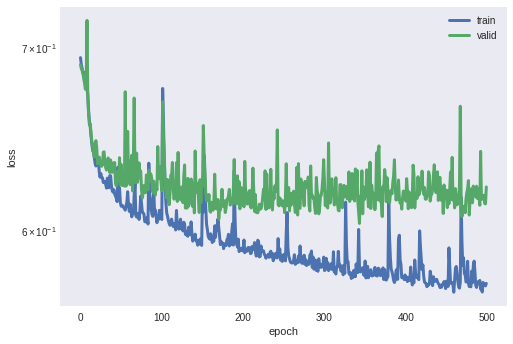

In [35]:
# X = X.toarray()
# X = X.reshape((X.shape[0],X.shape[1],1))

# X_test = X_test.toarray()
# X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

# print(X.shape)
# print(X_test.shape)



model = cnn_modelv7(input_shape=X.shape)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=500)
test_model(model,X_test,y_test)
plot_loss(hist)

#### Trying Max pooling

In [0]:
def cnn_modelv8(input_shape):

  from keras.models import Model
  from keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Flatten,AveragePooling1D,GlobalAveragePooling1D

  input_layer = Input(shape=(input_shape[1],input_shape[2],))
  x = Conv1D(32, 5, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_layer)
  x = MaxPooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Conv1D(16, 5, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = MaxPooling1D(pool_size=3, strides=None, padding='valid')(x)

  x = Conv1D(8, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = MaxPooling1D(pool_size=3, strides=None, padding='valid')(x)
 
  x = Conv1D(2, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = MaxPooling1D(pool_size=3, strides=None, padding='valid')(x)
  
  output_layer = GlobalAveragePooling1D()(x)
 
  #output_layer = Dense(2,activation='softmax')(x)
  model = Model(inputs=input_layer, outputs=output_layer)

  model.summary()

  return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 8000, 1)           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 7996, 32)          192       
_________________________________________________________________
average_pooling1d_46 (Averag (None, 2665, 32)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 2661, 16)          2576      
_________________________________________________________________
average_pooling1d_47 (Averag (None, 887, 16)           0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 885, 8)            392       
_________________________________________________________________
average_pooling1d_48 (Averag (None, 295, 8)            0         
__________

20000/20000 [==============================] - 15s 762us/step - loss: 0.6945 - acc: 0.5050 - val_loss: 0.6931 - val_acc: 0.4990
Epoch 2/200
20000/20000 [==============================] - 14s 711us/step - loss: 0.6934 - acc: 0.5051 - val_loss: 0.6931 - val_acc: 0.5012
Epoch 3/200
10304/20000 [==============>...............] - ETA: 6s - loss: 0.6934 - acc: 0.5015

20000/20000 [==============================] - 14s 712us/step - loss: 0.6933 - acc: 0.5015 - val_loss: 0.6931 - val_acc: 0.5010
Epoch 4/200
20000/20000 [==============================] - 14s 713us/step - loss: 0.6930 - acc: 0.5095 - val_loss: 0.6930 - val_acc: 0.4990
Epoch 5/200
11424/20000 [================>.............] - ETA: 5s - loss: 0.6928 - acc: 0.5095

20000/20000 [==============================] - 14s 711us/step - loss: 0.6927 - acc: 0.5113 - val_loss: 0.6920 - val_acc: 0.5318
Epoch 6/200
20000/20000 [==============================] - 14s 712us/step - loss: 0.6909 - acc: 0.5267 - val_loss: 0.6853 - val_acc: 0.5712
Epoch 7/200
11648/20000 [================>.............] - ETA: 5s - loss: 0.6766 - acc: 0.5835

20000/20000 [==============================] - 14s 714us/step - loss: 0.6762 - acc: 0.5866 - val_loss: 0.6698 - val_acc: 0.5992
Epoch 8/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6675 - acc: 0.5944 - val_loss: 0.6660 - val_acc: 0.6050
Epoch 9/200
11712/20000 [================>.............] - ETA: 5s - loss: 0.6638 - acc: 0.6052

20000/20000 [==============================] - 14s 718us/step - loss: 0.6646 - acc: 0.6011 - val_loss: 0.6718 - val_acc: 0.5832
Epoch 10/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.6621 - acc: 0.6065 - val_loss: 0.6631 - val_acc: 0.6158
Epoch 11/200
11744/20000 [================>.............] - ETA: 5s - loss: 0.6576 - acc: 0.6138

20000/20000 [==============================] - 14s 720us/step - loss: 0.6597 - acc: 0.6099 - val_loss: 0.6628 - val_acc: 0.6084
Epoch 12/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6584 - acc: 0.6121 - val_loss: 0.6586 - val_acc: 0.6202
Epoch 13/200
11520/20000 [================>.............] - ETA: 5s - loss: 0.6562 - acc: 0.6119

20000/20000 [==============================] - 14s 721us/step - loss: 0.6569 - acc: 0.6124 - val_loss: 0.6582 - val_acc: 0.6124
Epoch 14/200
20000/20000 [==============================] - 14s 720us/step - loss: 0.6551 - acc: 0.6173 - val_loss: 0.6564 - val_acc: 0.6202
Epoch 15/200
11264/20000 [===============>..............] - ETA: 5s - loss: 0.6531 - acc: 0.6178

20000/20000 [==============================] - 14s 719us/step - loss: 0.6532 - acc: 0.6181 - val_loss: 0.6539 - val_acc: 0.6202
Epoch 16/200
20000/20000 [==============================] - 14s 723us/step - loss: 0.6521 - acc: 0.6210 - val_loss: 0.6517 - val_acc: 0.6234
Epoch 17/200
11488/20000 [================>.............] - ETA: 5s - loss: 0.6531 - acc: 0.6214

20000/20000 [==============================] - 14s 716us/step - loss: 0.6506 - acc: 0.6237 - val_loss: 0.6506 - val_acc: 0.6230
Epoch 18/200
20000/20000 [==============================] - 14s 720us/step - loss: 0.6492 - acc: 0.6250 - val_loss: 0.6488 - val_acc: 0.6258
Epoch 19/200
11520/20000 [================>.............] - ETA: 5s - loss: 0.6514 - acc: 0.6214

20000/20000 [==============================] - 14s 717us/step - loss: 0.6508 - acc: 0.6240 - val_loss: 0.6531 - val_acc: 0.6180
Epoch 20/200
20000/20000 [==============================] - 14s 721us/step - loss: 0.6467 - acc: 0.6298 - val_loss: 0.6478 - val_acc: 0.6242
Epoch 21/200
11456/20000 [================>.............] - ETA: 5s - loss: 0.6455 - acc: 0.6303

20000/20000 [==============================] - 14s 716us/step - loss: 0.6445 - acc: 0.6307 - val_loss: 0.6589 - val_acc: 0.6102
Epoch 22/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6424 - acc: 0.6345 - val_loss: 0.6448 - val_acc: 0.6262
Epoch 23/200
11456/20000 [================>.............] - ETA: 5s - loss: 0.6428 - acc: 0.6321

20000/20000 [==============================] - 14s 720us/step - loss: 0.6415 - acc: 0.6351 - val_loss: 0.6588 - val_acc: 0.6240
Epoch 24/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.6401 - acc: 0.6366 - val_loss: 0.6442 - val_acc: 0.6378
Epoch 25/200
11584/20000 [================>.............] - ETA: 5s - loss: 0.6360 - acc: 0.6405

20000/20000 [==============================] - 14s 721us/step - loss: 0.6374 - acc: 0.6394 - val_loss: 0.6485 - val_acc: 0.6310
Epoch 26/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6393 - acc: 0.6411 - val_loss: 0.6444 - val_acc: 0.6342
Epoch 27/200
11584/20000 [================>.............] - ETA: 5s - loss: 0.6360 - acc: 0.6427

20000/20000 [==============================] - 14s 721us/step - loss: 0.6360 - acc: 0.6414 - val_loss: 0.6473 - val_acc: 0.6304
Epoch 28/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6362 - acc: 0.6441 - val_loss: 0.6452 - val_acc: 0.6330
Epoch 29/200
11712/20000 [================>.............] - ETA: 5s - loss: 0.6308 - acc: 0.6469

20000/20000 [==============================] - 14s 718us/step - loss: 0.6327 - acc: 0.6446 - val_loss: 0.6501 - val_acc: 0.6300
Epoch 30/200
20000/20000 [==============================] - 14s 715us/step - loss: 0.6336 - acc: 0.6447 - val_loss: 0.6519 - val_acc: 0.6276
Epoch 31/200
11552/20000 [================>.............] - ETA: 5s - loss: 0.6324 - acc: 0.6467

20000/20000 [==============================] - 14s 716us/step - loss: 0.6324 - acc: 0.6456 - val_loss: 0.6438 - val_acc: 0.6396
Epoch 32/200
20000/20000 [==============================] - 14s 715us/step - loss: 0.6308 - acc: 0.6467 - val_loss: 0.6428 - val_acc: 0.6408
Epoch 33/200
11392/20000 [================>.............] - ETA: 5s - loss: 0.6298 - acc: 0.6563

20000/20000 [==============================] - 14s 724us/step - loss: 0.6300 - acc: 0.6511 - val_loss: 0.6373 - val_acc: 0.6508
Epoch 34/200
20000/20000 [==============================] - 14s 721us/step - loss: 0.6286 - acc: 0.6532 - val_loss: 0.6359 - val_acc: 0.6490
Epoch 35/200
11360/20000 [================>.............] - ETA: 5s - loss: 0.6316 - acc: 0.6535

20000/20000 [==============================] - 14s 720us/step - loss: 0.6277 - acc: 0.6572 - val_loss: 0.6360 - val_acc: 0.6492
Epoch 36/200
20000/20000 [==============================] - 14s 715us/step - loss: 0.6273 - acc: 0.6545 - val_loss: 0.6393 - val_acc: 0.6488
Epoch 37/200
11424/20000 [================>.............] - ETA: 5s - loss: 0.6255 - acc: 0.6571

20000/20000 [==============================] - 14s 724us/step - loss: 0.6256 - acc: 0.6592 - val_loss: 0.6354 - val_acc: 0.6560
Epoch 38/200
20000/20000 [==============================] - 14s 721us/step - loss: 0.6242 - acc: 0.6582 - val_loss: 0.6395 - val_acc: 0.6440
Epoch 39/200
11232/20000 [===============>..............] - ETA: 5s - loss: 0.6249 - acc: 0.6550

20000/20000 [==============================] - 14s 719us/step - loss: 0.6252 - acc: 0.6546 - val_loss: 0.6411 - val_acc: 0.6426
Epoch 40/200
20000/20000 [==============================] - 14s 712us/step - loss: 0.6306 - acc: 0.6500 - val_loss: 0.6355 - val_acc: 0.6448
Epoch 41/200
11616/20000 [================>.............] - ETA: 5s - loss: 0.6300 - acc: 0.6491

20000/20000 [==============================] - 14s 720us/step - loss: 0.6277 - acc: 0.6498 - val_loss: 0.6355 - val_acc: 0.6490
Epoch 42/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6233 - acc: 0.6590 - val_loss: 0.6333 - val_acc: 0.6558
Epoch 43/200
11680/20000 [================>.............] - ETA: 5s - loss: 0.6209 - acc: 0.6639

20000/20000 [==============================] - 14s 719us/step - loss: 0.6218 - acc: 0.6599 - val_loss: 0.6316 - val_acc: 0.6548
Epoch 44/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6206 - acc: 0.6608 - val_loss: 0.6377 - val_acc: 0.6434
Epoch 45/200
11744/20000 [================>.............] - ETA: 5s - loss: 0.6179 - acc: 0.6623

20000/20000 [==============================] - 14s 718us/step - loss: 0.6201 - acc: 0.6616 - val_loss: 0.6362 - val_acc: 0.6464
Epoch 46/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6208 - acc: 0.6605 - val_loss: 0.6332 - val_acc: 0.6534
Epoch 47/200
11808/20000 [================>.............] - ETA: 5s - loss: 0.6192 - acc: 0.6640

20000/20000 [==============================] - 14s 718us/step - loss: 0.6191 - acc: 0.6639 - val_loss: 0.6409 - val_acc: 0.6518
Epoch 48/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6200 - acc: 0.6640 - val_loss: 0.6519 - val_acc: 0.6404
Epoch 49/200
11712/20000 [================>.............] - ETA: 5s - loss: 0.6249 - acc: 0.6586

20000/20000 [==============================] - 14s 718us/step - loss: 0.6199 - acc: 0.6613 - val_loss: 0.6297 - val_acc: 0.6582
Epoch 50/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.6199 - acc: 0.6612 - val_loss: 0.6305 - val_acc: 0.6550
Epoch 51/200
11648/20000 [================>.............] - ETA: 5s - loss: 0.6232 - acc: 0.6551

20000/20000 [==============================] - 14s 718us/step - loss: 0.6205 - acc: 0.6584 - val_loss: 0.6337 - val_acc: 0.6468
Epoch 52/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.6191 - acc: 0.6598 - val_loss: 0.6361 - val_acc: 0.6514
Epoch 53/200
11680/20000 [================>.............] - ETA: 5s - loss: 0.6168 - acc: 0.6606

20000/20000 [==============================] - 14s 715us/step - loss: 0.6176 - acc: 0.6596 - val_loss: 0.6324 - val_acc: 0.6540
Epoch 54/200
20000/20000 [==============================] - 14s 720us/step - loss: 0.6170 - acc: 0.6654 - val_loss: 0.6298 - val_acc: 0.6656
Epoch 55/200
11584/20000 [================>.............] - ETA: 5s - loss: 0.6167 - acc: 0.6656

20000/20000 [==============================] - 14s 718us/step - loss: 0.6173 - acc: 0.6661 - val_loss: 0.6271 - val_acc: 0.6610
Epoch 56/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6154 - acc: 0.6634 - val_loss: 0.6433 - val_acc: 0.6480
Epoch 57/200
11712/20000 [================>.............] - ETA: 5s - loss: 0.6184 - acc: 0.6615

20000/20000 [==============================] - 14s 717us/step - loss: 0.6173 - acc: 0.6649 - val_loss: 0.6279 - val_acc: 0.6618
Epoch 58/200
20000/20000 [==============================] - 14s 714us/step - loss: 0.6152 - acc: 0.6648 - val_loss: 0.6304 - val_acc: 0.6586
Epoch 59/200
11680/20000 [================>.............] - ETA: 5s - loss: 0.6202 - acc: 0.6634

20000/20000 [==============================] - 14s 713us/step - loss: 0.6223 - acc: 0.6601 - val_loss: 0.6429 - val_acc: 0.6462
Epoch 60/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6203 - acc: 0.6614 - val_loss: 0.6295 - val_acc: 0.6604
Epoch 61/200
11552/20000 [================>.............] - ETA: 5s - loss: 0.6183 - acc: 0.6646

20000/20000 [==============================] - 14s 722us/step - loss: 0.6182 - acc: 0.6658 - val_loss: 0.6333 - val_acc: 0.6478
Epoch 62/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.6184 - acc: 0.6666 - val_loss: 0.6370 - val_acc: 0.6508
Epoch 63/200
11232/20000 [===============>..............] - ETA: 5s - loss: 0.6165 - acc: 0.6717

20000/20000 [==============================] - 14s 718us/step - loss: 0.6238 - acc: 0.6615 - val_loss: 0.6337 - val_acc: 0.6476
Epoch 64/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6247 - acc: 0.6542 - val_loss: 0.6410 - val_acc: 0.6374
Epoch 65/200
11328/20000 [===============>..............] - ETA: 5s - loss: 0.6197 - acc: 0.6614

20000/20000 [==============================] - 14s 720us/step - loss: 0.6191 - acc: 0.6630 - val_loss: 0.6297 - val_acc: 0.6600
Epoch 66/200
20000/20000 [==============================] - 14s 715us/step - loss: 0.6168 - acc: 0.6626 - val_loss: 0.6323 - val_acc: 0.6544
Epoch 67/200
11456/20000 [================>.............] - ETA: 5s - loss: 0.6164 - acc: 0.6669

20000/20000 [==============================] - 14s 715us/step - loss: 0.6161 - acc: 0.6667 - val_loss: 0.6453 - val_acc: 0.6402
Epoch 68/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.6144 - acc: 0.6698 - val_loss: 0.6287 - val_acc: 0.6588
Epoch 69/200
11712/20000 [================>.............] - ETA: 5s - loss: 0.6116 - acc: 0.6698

20000/20000 [==============================] - 14s 719us/step - loss: 0.6137 - acc: 0.6655 - val_loss: 0.6290 - val_acc: 0.6660
Epoch 70/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.6134 - acc: 0.6692 - val_loss: 0.6287 - val_acc: 0.6624
Epoch 71/200
11520/20000 [================>.............] - ETA: 5s - loss: 0.6141 - acc: 0.6648

20000/20000 [==============================] - 14s 723us/step - loss: 0.6135 - acc: 0.6680 - val_loss: 0.6277 - val_acc: 0.6590
Epoch 72/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6128 - acc: 0.6722 - val_loss: 0.6242 - val_acc: 0.6638
Epoch 73/200
11680/20000 [================>.............] - ETA: 5s - loss: 0.6151 - acc: 0.6694

20000/20000 [==============================] - 14s 720us/step - loss: 0.6140 - acc: 0.6687 - val_loss: 0.6250 - val_acc: 0.6634
Epoch 74/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6125 - acc: 0.6690 - val_loss: 0.6433 - val_acc: 0.6468
Epoch 75/200
11680/20000 [================>.............] - ETA: 5s - loss: 0.6106 - acc: 0.6705

20000/20000 [==============================] - 14s 716us/step - loss: 0.6135 - acc: 0.6672 - val_loss: 0.6339 - val_acc: 0.6588
Epoch 76/200
20000/20000 [==============================] - 14s 721us/step - loss: 0.6126 - acc: 0.6697 - val_loss: 0.6242 - val_acc: 0.6634
Epoch 77/200
11616/20000 [================>.............] - ETA: 5s - loss: 0.6069 - acc: 0.6774

20000/20000 [==============================] - 14s 717us/step - loss: 0.6111 - acc: 0.6713 - val_loss: 0.6316 - val_acc: 0.6598
Epoch 78/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.6106 - acc: 0.6707 - val_loss: 0.6417 - val_acc: 0.6490
Epoch 79/200
11552/20000 [================>.............] - ETA: 5s - loss: 0.6114 - acc: 0.6691

20000/20000 [==============================] - 14s 723us/step - loss: 0.6116 - acc: 0.6699 - val_loss: 0.6330 - val_acc: 0.6458
Epoch 80/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6122 - acc: 0.6671 - val_loss: 0.6291 - val_acc: 0.6554
Epoch 81/200
11584/20000 [================>.............] - ETA: 5s - loss: 0.6137 - acc: 0.6698

20000/20000 [==============================] - 14s 716us/step - loss: 0.6125 - acc: 0.6678 - val_loss: 0.6266 - val_acc: 0.6546
Epoch 82/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.6117 - acc: 0.6691 - val_loss: 0.6312 - val_acc: 0.6512
Epoch 83/200
11264/20000 [===============>..............] - ETA: 5s - loss: 0.6101 - acc: 0.6699

20000/20000 [==============================] - 14s 718us/step - loss: 0.6129 - acc: 0.6682 - val_loss: 0.6255 - val_acc: 0.6640
Epoch 84/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6080 - acc: 0.6716 - val_loss: 0.6291 - val_acc: 0.6540
Epoch 85/200
11648/20000 [================>.............] - ETA: 5s - loss: 0.6075 - acc: 0.6738

20000/20000 [==============================] - 14s 717us/step - loss: 0.6090 - acc: 0.6716 - val_loss: 0.6297 - val_acc: 0.6538
Epoch 86/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6076 - acc: 0.6744 - val_loss: 0.6272 - val_acc: 0.6586
Epoch 87/200
11520/20000 [================>.............] - ETA: 5s - loss: 0.6072 - acc: 0.6724

20000/20000 [==============================] - 14s 722us/step - loss: 0.6079 - acc: 0.6729 - val_loss: 0.6235 - val_acc: 0.6602
Epoch 88/200
20000/20000 [==============================] - 14s 720us/step - loss: 0.6106 - acc: 0.6739 - val_loss: 0.6251 - val_acc: 0.6570
Epoch 89/200
11616/20000 [================>.............] - ETA: 5s - loss: 0.6073 - acc: 0.6732

20000/20000 [==============================] - 14s 717us/step - loss: 0.6085 - acc: 0.6704 - val_loss: 0.6249 - val_acc: 0.6588
Epoch 90/200
20000/20000 [==============================] - 14s 722us/step - loss: 0.6082 - acc: 0.6702 - val_loss: 0.6251 - val_acc: 0.6624
Epoch 91/200
11552/20000 [================>.............] - ETA: 5s - loss: 0.6113 - acc: 0.6728

20000/20000 [==============================] - 14s 715us/step - loss: 0.6080 - acc: 0.6732 - val_loss: 0.6243 - val_acc: 0.6598
Epoch 92/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.6063 - acc: 0.6742 - val_loss: 0.6240 - val_acc: 0.6600
Epoch 93/200
11584/20000 [================>.............] - ETA: 5s - loss: 0.6052 - acc: 0.6783

20000/20000 [==============================] - 14s 721us/step - loss: 0.6072 - acc: 0.6736 - val_loss: 0.6240 - val_acc: 0.6638
Epoch 94/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6084 - acc: 0.6751 - val_loss: 0.6296 - val_acc: 0.6570
Epoch 95/200
11712/20000 [================>.............] - ETA: 5s - loss: 0.6049 - acc: 0.6812

20000/20000 [==============================] - 14s 718us/step - loss: 0.6059 - acc: 0.6762 - val_loss: 0.6276 - val_acc: 0.6630
Epoch 96/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6122 - acc: 0.6686 - val_loss: 0.6289 - val_acc: 0.6504
Epoch 97/200
11712/20000 [================>.............] - ETA: 5s - loss: 0.6116 - acc: 0.6725

20000/20000 [==============================] - 14s 719us/step - loss: 0.6104 - acc: 0.6724 - val_loss: 0.6259 - val_acc: 0.6558
Epoch 98/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.6070 - acc: 0.6764 - val_loss: 0.6338 - val_acc: 0.6558
Epoch 99/200
11520/20000 [================>.............] - ETA: 5s - loss: 0.6071 - acc: 0.6734

20000/20000 [==============================] - 14s 716us/step - loss: 0.6052 - acc: 0.6768 - val_loss: 0.6249 - val_acc: 0.6614
Epoch 100/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6042 - acc: 0.6780 - val_loss: 0.6241 - val_acc: 0.6594
Epoch 101/200
11552/20000 [================>.............] - ETA: 5s - loss: 0.6089 - acc: 0.6757

20000/20000 [==============================] - 14s 716us/step - loss: 0.6040 - acc: 0.6795 - val_loss: 0.6272 - val_acc: 0.6586
Epoch 102/200
20000/20000 [==============================] - 14s 715us/step - loss: 0.6045 - acc: 0.6774 - val_loss: 0.6282 - val_acc: 0.6574
Epoch 103/200
11584/20000 [================>.............] - ETA: 5s - loss: 0.6040 - acc: 0.6751

20000/20000 [==============================] - 14s 719us/step - loss: 0.6211 - acc: 0.6649 - val_loss: 0.6267 - val_acc: 0.6538
Epoch 104/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.6133 - acc: 0.6710 - val_loss: 0.6216 - val_acc: 0.6578
Epoch 105/200
11552/20000 [================>.............] - ETA: 5s - loss: 0.6053 - acc: 0.6788

20000/20000 [==============================] - 15s 727us/step - loss: 0.6079 - acc: 0.6757 - val_loss: 0.6186 - val_acc: 0.6564
Epoch 106/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6077 - acc: 0.6714 - val_loss: 0.6226 - val_acc: 0.6542
Epoch 107/200
11008/20000 [===============>..............] - ETA: 6s - loss: 0.6014 - acc: 0.6783

20000/20000 [==============================] - 14s 724us/step - loss: 0.6046 - acc: 0.6754 - val_loss: 0.6214 - val_acc: 0.6570
Epoch 108/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.6083 - acc: 0.6694 - val_loss: 0.6238 - val_acc: 0.6552
Epoch 109/200
11328/20000 [===============>..............] - ETA: 5s - loss: 0.6035 - acc: 0.6747

20000/20000 [==============================] - 14s 719us/step - loss: 0.6046 - acc: 0.6751 - val_loss: 0.6241 - val_acc: 0.6556
Epoch 110/200
20000/20000 [==============================] - 14s 720us/step - loss: 0.6014 - acc: 0.6777 - val_loss: 0.6201 - val_acc: 0.6592
Epoch 111/200
11424/20000 [================>.............] - ETA: 5s - loss: 0.6045 - acc: 0.6774

20000/20000 [==============================] - 14s 719us/step - loss: 0.6012 - acc: 0.6780 - val_loss: 0.6238 - val_acc: 0.6534
Epoch 112/200
20000/20000 [==============================] - 14s 715us/step - loss: 0.6007 - acc: 0.6777 - val_loss: 0.6241 - val_acc: 0.6608
Epoch 113/200
11584/20000 [================>.............] - ETA: 5s - loss: 0.6014 - acc: 0.6823

20000/20000 [==============================] - 14s 718us/step - loss: 0.6030 - acc: 0.6786 - val_loss: 0.6249 - val_acc: 0.6584
Epoch 114/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.6010 - acc: 0.6794 - val_loss: 0.6265 - val_acc: 0.6568
Epoch 115/200
11520/20000 [================>.............] - ETA: 5s - loss: 0.5984 - acc: 0.6830

20000/20000 [==============================] - 14s 713us/step - loss: 0.6000 - acc: 0.6798 - val_loss: 0.6284 - val_acc: 0.6542
Epoch 116/200
20000/20000 [==============================] - 14s 715us/step - loss: 0.6009 - acc: 0.6785 - val_loss: 0.6274 - val_acc: 0.6570
Epoch 117/200
11456/20000 [================>.............] - ETA: 5s - loss: 0.6003 - acc: 0.6796

20000/20000 [==============================] - 14s 717us/step - loss: 0.6012 - acc: 0.6782 - val_loss: 0.6284 - val_acc: 0.6544
Epoch 118/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.6013 - acc: 0.6762 - val_loss: 0.6253 - val_acc: 0.6592
Epoch 119/200
11232/20000 [===============>..............] - ETA: 5s - loss: 0.5985 - acc: 0.6803

20000/20000 [==============================] - 14s 718us/step - loss: 0.6019 - acc: 0.6774 - val_loss: 0.6211 - val_acc: 0.6610
Epoch 120/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.6022 - acc: 0.6804 - val_loss: 0.6189 - val_acc: 0.6604
Epoch 121/200
11456/20000 [================>.............] - ETA: 5s - loss: 0.5999 - acc: 0.6793

20000/20000 [==============================] - 14s 718us/step - loss: 0.6004 - acc: 0.6786 - val_loss: 0.6170 - val_acc: 0.6666
Epoch 122/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.6027 - acc: 0.6774 - val_loss: 0.6310 - val_acc: 0.6570
Epoch 123/200
11392/20000 [================>.............] - ETA: 5s - loss: 0.6038 - acc: 0.6747

20000/20000 [==============================] - 14s 715us/step - loss: 0.6051 - acc: 0.6736 - val_loss: 0.6236 - val_acc: 0.6598
Epoch 124/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.5985 - acc: 0.6789 - val_loss: 0.6214 - val_acc: 0.6658
Epoch 125/200
11296/20000 [===============>..............] - ETA: 5s - loss: 0.5969 - acc: 0.6845

20000/20000 [==============================] - 14s 718us/step - loss: 0.5990 - acc: 0.6818 - val_loss: 0.6285 - val_acc: 0.6644
Epoch 126/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.6004 - acc: 0.6807 - val_loss: 0.6269 - val_acc: 0.6544
Epoch 127/200
11424/20000 [================>.............] - ETA: 5s - loss: 0.5977 - acc: 0.6797

20000/20000 [==============================] - 14s 722us/step - loss: 0.5999 - acc: 0.6774 - val_loss: 0.6233 - val_acc: 0.6596
Epoch 128/200
20000/20000 [==============================] - 14s 715us/step - loss: 0.5994 - acc: 0.6785 - val_loss: 0.6292 - val_acc: 0.6466
Epoch 129/200
11200/20000 [===============>..............] - ETA: 5s - loss: 0.5995 - acc: 0.6756

20000/20000 [==============================] - 14s 720us/step - loss: 0.5994 - acc: 0.6795 - val_loss: 0.6232 - val_acc: 0.6568
Epoch 130/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.5968 - acc: 0.6821 - val_loss: 0.6185 - val_acc: 0.6560
Epoch 131/200
11424/20000 [================>.............] - ETA: 5s - loss: 0.5971 - acc: 0.6803

20000/20000 [==============================] - 14s 724us/step - loss: 0.5965 - acc: 0.6830 - val_loss: 0.6165 - val_acc: 0.6662
Epoch 132/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.5992 - acc: 0.6823 - val_loss: 0.6166 - val_acc: 0.6670
Epoch 133/200
11520/20000 [================>.............] - ETA: 5s - loss: 0.5952 - acc: 0.6812

20000/20000 [==============================] - 14s 716us/step - loss: 0.5989 - acc: 0.6802 - val_loss: 0.6192 - val_acc: 0.6606
Epoch 134/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.5965 - acc: 0.6839 - val_loss: 0.6180 - val_acc: 0.6626
Epoch 135/200
11296/20000 [===============>..............] - ETA: 5s - loss: 0.5938 - acc: 0.6818

20000/20000 [==============================] - 14s 716us/step - loss: 0.5971 - acc: 0.6824 - val_loss: 0.6178 - val_acc: 0.6600
Epoch 136/200
20000/20000 [==============================] - 14s 720us/step - loss: 0.5975 - acc: 0.6804 - val_loss: 0.6214 - val_acc: 0.6600
Epoch 137/200
11424/20000 [================>.............] - ETA: 5s - loss: 0.6015 - acc: 0.6777

20000/20000 [==============================] - 14s 713us/step - loss: 0.5962 - acc: 0.6821 - val_loss: 0.6180 - val_acc: 0.6612
Epoch 138/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.5935 - acc: 0.6850 - val_loss: 0.6223 - val_acc: 0.6596
Epoch 139/200
11488/20000 [================>.............] - ETA: 5s - loss: 0.5930 - acc: 0.6880

20000/20000 [==============================] - 14s 712us/step - loss: 0.5966 - acc: 0.6827 - val_loss: 0.6244 - val_acc: 0.6620
Epoch 140/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.5938 - acc: 0.6854 - val_loss: 0.6249 - val_acc: 0.6654
Epoch 141/200
11520/20000 [================>.............] - ETA: 5s - loss: 0.5938 - acc: 0.6861

20000/20000 [==============================] - 14s 720us/step - loss: 0.5953 - acc: 0.6845 - val_loss: 0.6178 - val_acc: 0.6632
Epoch 142/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.5936 - acc: 0.6838 - val_loss: 0.6335 - val_acc: 0.6450
Epoch 143/200
11584/20000 [================>.............] - ETA: 5s - loss: 0.5925 - acc: 0.6901

20000/20000 [==============================] - 14s 714us/step - loss: 0.5948 - acc: 0.6856 - val_loss: 0.6267 - val_acc: 0.6620
Epoch 144/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.5934 - acc: 0.6848 - val_loss: 0.6218 - val_acc: 0.6566
Epoch 145/200
11552/20000 [================>.............] - ETA: 5s - loss: 0.5955 - acc: 0.6833

20000/20000 [==============================] - 14s 721us/step - loss: 0.5935 - acc: 0.6855 - val_loss: 0.6202 - val_acc: 0.6630
Epoch 146/200
20000/20000 [==============================] - 14s 723us/step - loss: 0.5981 - acc: 0.6812 - val_loss: 0.6179 - val_acc: 0.6622
Epoch 147/200
11552/20000 [================>.............] - ETA: 5s - loss: 0.5998 - acc: 0.6750

20000/20000 [==============================] - 14s 716us/step - loss: 0.6022 - acc: 0.6752 - val_loss: 0.6209 - val_acc: 0.6504
Epoch 148/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.5973 - acc: 0.6812 - val_loss: 0.6204 - val_acc: 0.6546
Epoch 149/200
11200/20000 [===============>..............] - ETA: 5s - loss: 0.5915 - acc: 0.6864

20000/20000 [==============================] - 14s 719us/step - loss: 0.5940 - acc: 0.6855 - val_loss: 0.6199 - val_acc: 0.6560
Epoch 150/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.5934 - acc: 0.6872 - val_loss: 0.6254 - val_acc: 0.6572
Epoch 151/200
11520/20000 [================>.............] - ETA: 5s - loss: 0.5927 - acc: 0.6866

20000/20000 [==============================] - 14s 714us/step - loss: 0.5932 - acc: 0.6870 - val_loss: 0.6208 - val_acc: 0.6616
Epoch 152/200
20000/20000 [==============================] - 14s 721us/step - loss: 0.5931 - acc: 0.6845 - val_loss: 0.6151 - val_acc: 0.6644
Epoch 153/200
11488/20000 [================>.............] - ETA: 5s - loss: 0.5864 - acc: 0.6901

20000/20000 [==============================] - 14s 720us/step - loss: 0.5922 - acc: 0.6853 - val_loss: 0.6242 - val_acc: 0.6558
Epoch 154/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.5921 - acc: 0.6885 - val_loss: 0.6308 - val_acc: 0.6530
Epoch 155/200
11296/20000 [===============>..............] - ETA: 5s - loss: 0.5939 - acc: 0.6858

20000/20000 [==============================] - 14s 719us/step - loss: 0.5935 - acc: 0.6865 - val_loss: 0.6194 - val_acc: 0.6624
Epoch 156/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.5918 - acc: 0.6870 - val_loss: 0.6171 - val_acc: 0.6578
Epoch 157/200
11488/20000 [================>.............] - ETA: 5s - loss: 0.5923 - acc: 0.6881

20000/20000 [==============================] - 14s 720us/step - loss: 0.5916 - acc: 0.6901 - val_loss: 0.6262 - val_acc: 0.6574
Epoch 158/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.5913 - acc: 0.6898 - val_loss: 0.6231 - val_acc: 0.6568
Epoch 159/200
11488/20000 [================>.............] - ETA: 5s - loss: 0.5900 - acc: 0.6922

20000/20000 [==============================] - 14s 717us/step - loss: 0.5933 - acc: 0.6879 - val_loss: 0.6187 - val_acc: 0.6614
Epoch 160/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.5907 - acc: 0.6901 - val_loss: 0.6284 - val_acc: 0.6506
Epoch 161/200
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5901 - acc: 0.6908

20000/20000 [==============================] - 14s 720us/step - loss: 0.5999 - acc: 0.6786 - val_loss: 0.6205 - val_acc: 0.6570
Epoch 162/200
20000/20000 [==============================] - 14s 714us/step - loss: 0.6004 - acc: 0.6801 - val_loss: 0.6144 - val_acc: 0.6614
Epoch 163/200
11456/20000 [================>.............] - ETA: 5s - loss: 0.5920 - acc: 0.6893

20000/20000 [==============================] - 14s 719us/step - loss: 0.5963 - acc: 0.6841 - val_loss: 0.6141 - val_acc: 0.6660
Epoch 164/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.5955 - acc: 0.6855 - val_loss: 0.6134 - val_acc: 0.6612
Epoch 165/200
11072/20000 [===============>..............] - ETA: 5s - loss: 0.5929 - acc: 0.6895

20000/20000 [==============================] - 14s 719us/step - loss: 0.5949 - acc: 0.6857 - val_loss: 0.6139 - val_acc: 0.6610
Epoch 166/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.5964 - acc: 0.6834 - val_loss: 0.6168 - val_acc: 0.6596
Epoch 167/200
11232/20000 [===============>..............] - ETA: 5s - loss: 0.5947 - acc: 0.6822

20000/20000 [==============================] - 14s 720us/step - loss: 0.5931 - acc: 0.6854 - val_loss: 0.6140 - val_acc: 0.6620
Epoch 168/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.5969 - acc: 0.6816 - val_loss: 0.6233 - val_acc: 0.6600
Epoch 169/200
11392/20000 [================>.............] - ETA: 5s - loss: 0.6092 - acc: 0.6677

20000/20000 [==============================] - 14s 720us/step - loss: 0.6047 - acc: 0.6714 - val_loss: 0.6141 - val_acc: 0.6608
Epoch 170/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.5947 - acc: 0.6821 - val_loss: 0.6129 - val_acc: 0.6642
Epoch 171/200
11136/20000 [===============>..............] - ETA: 5s - loss: 0.5907 - acc: 0.6875

20000/20000 [==============================] - 15s 727us/step - loss: 0.5944 - acc: 0.6836 - val_loss: 0.6221 - val_acc: 0.6614
Epoch 172/200
20000/20000 [==============================] - 14s 720us/step - loss: 0.5971 - acc: 0.6830 - val_loss: 0.6203 - val_acc: 0.6588
Epoch 173/200
11072/20000 [===============>..............] - ETA: 5s - loss: 0.5909 - acc: 0.6895

20000/20000 [==============================] - 14s 720us/step - loss: 0.5920 - acc: 0.6864 - val_loss: 0.6197 - val_acc: 0.6564
Epoch 174/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.5887 - acc: 0.6891 - val_loss: 0.6335 - val_acc: 0.6502
Epoch 175/200
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5885 - acc: 0.6894

20000/20000 [==============================] - 14s 717us/step - loss: 0.5925 - acc: 0.6853 - val_loss: 0.6174 - val_acc: 0.6624
Epoch 176/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.5933 - acc: 0.6874 - val_loss: 0.6221 - val_acc: 0.6626
Epoch 177/200
11328/20000 [===============>..............] - ETA: 5s - loss: 0.5881 - acc: 0.6906

20000/20000 [==============================] - 14s 721us/step - loss: 0.5908 - acc: 0.6868 - val_loss: 0.6209 - val_acc: 0.6580
Epoch 178/200
20000/20000 [==============================] - 14s 713us/step - loss: 0.5906 - acc: 0.6889 - val_loss: 0.6230 - val_acc: 0.6610
Epoch 179/200
11616/20000 [================>.............] - ETA: 5s - loss: 0.5868 - acc: 0.6919

20000/20000 [==============================] - 14s 719us/step - loss: 0.5907 - acc: 0.6868 - val_loss: 0.6170 - val_acc: 0.6630
Epoch 180/200
20000/20000 [==============================] - 14s 723us/step - loss: 0.6065 - acc: 0.6778 - val_loss: 0.6268 - val_acc: 0.6596
Epoch 181/200
11232/20000 [===============>..............] - ETA: 5s - loss: 0.5996 - acc: 0.6821

20000/20000 [==============================] - 14s 720us/step - loss: 0.5991 - acc: 0.6812 - val_loss: 0.6210 - val_acc: 0.6492
Epoch 182/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.5972 - acc: 0.6812 - val_loss: 0.6226 - val_acc: 0.6616
Epoch 183/200
11424/20000 [================>.............] - ETA: 5s - loss: 0.5909 - acc: 0.6871

20000/20000 [==============================] - 14s 720us/step - loss: 0.5941 - acc: 0.6851 - val_loss: 0.6231 - val_acc: 0.6560
Epoch 184/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.5927 - acc: 0.6854 - val_loss: 0.6292 - val_acc: 0.6526
Epoch 185/200
11488/20000 [================>.............] - ETA: 5s - loss: 0.5900 - acc: 0.6887

20000/20000 [==============================] - 14s 718us/step - loss: 0.5983 - acc: 0.6825 - val_loss: 0.6242 - val_acc: 0.6510
Epoch 186/200
20000/20000 [==============================] - 14s 720us/step - loss: 0.5935 - acc: 0.6838 - val_loss: 0.6157 - val_acc: 0.6590
Epoch 187/200
11648/20000 [================>.............] - ETA: 5s - loss: 0.5919 - acc: 0.6866

20000/20000 [==============================] - 14s 717us/step - loss: 0.5908 - acc: 0.6889 - val_loss: 0.6241 - val_acc: 0.6538
Epoch 188/200
20000/20000 [==============================] - 14s 720us/step - loss: 0.5906 - acc: 0.6889 - val_loss: 0.6267 - val_acc: 0.6554
Epoch 189/200
11200/20000 [===============>..............] - ETA: 5s - loss: 0.5909 - acc: 0.6836

20000/20000 [==============================] - 14s 718us/step - loss: 0.5908 - acc: 0.6861 - val_loss: 0.6552 - val_acc: 0.6452
Epoch 190/200
20000/20000 [==============================] - 14s 723us/step - loss: 0.5903 - acc: 0.6885 - val_loss: 0.6267 - val_acc: 0.6550
Epoch 191/200
11360/20000 [================>.............] - ETA: 5s - loss: 0.5915 - acc: 0.6923

20000/20000 [==============================] - 14s 719us/step - loss: 0.5931 - acc: 0.6866 - val_loss: 0.6243 - val_acc: 0.6582
Epoch 192/200
20000/20000 [==============================] - 14s 721us/step - loss: 0.5907 - acc: 0.6878 - val_loss: 0.6262 - val_acc: 0.6500
Epoch 193/200
11168/20000 [===============>..............] - ETA: 5s - loss: 0.5873 - acc: 0.6883

20000/20000 [==============================] - 14s 719us/step - loss: 0.5896 - acc: 0.6859 - val_loss: 0.6144 - val_acc: 0.6566
Epoch 194/200
20000/20000 [==============================] - 14s 720us/step - loss: 0.5894 - acc: 0.6881 - val_loss: 0.6233 - val_acc: 0.6572
Epoch 195/200
10880/20000 [===============>..............] - ETA: 6s - loss: 0.5869 - acc: 0.6919

20000/20000 [==============================] - 14s 716us/step - loss: 0.5895 - acc: 0.6870 - val_loss: 0.6172 - val_acc: 0.6582
Epoch 196/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.5883 - acc: 0.6881 - val_loss: 0.6276 - val_acc: 0.6574
Epoch 197/200
11360/20000 [================>.............] - ETA: 5s - loss: 0.5843 - acc: 0.6902

20000/20000 [==============================] - 14s 716us/step - loss: 0.5905 - acc: 0.6865 - val_loss: 0.6131 - val_acc: 0.6588
Epoch 198/200
20000/20000 [==============================] - 14s 717us/step - loss: 0.5899 - acc: 0.6889 - val_loss: 0.6137 - val_acc: 0.6582
Epoch 199/200
11296/20000 [===============>..............] - ETA: 5s - loss: 0.5907 - acc: 0.6845

20000/20000 [==============================] - 14s 716us/step - loss: 0.5898 - acc: 0.6865 - val_loss: 0.6154 - val_acc: 0.6540
Epoch 200/200
20000/20000 [==============================] - 14s 718us/step - loss: 0.5899 - acc: 0.6893 - val_loss: 0.6287 - val_acc: 0.6552
Testing model on 25000
Test Accuracy: 66.084000


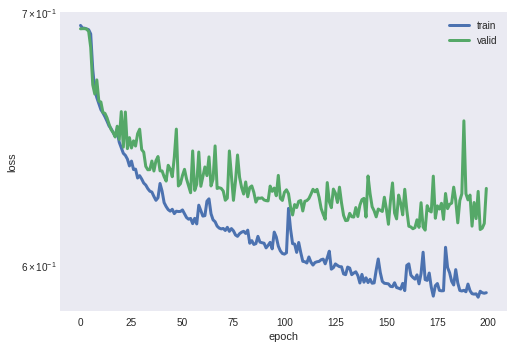

In [38]:
# X = X.toarray()
# X = X.reshape((X.shape[0],X.shape[1],1))

# X_test = X_test.toarray()
# X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

# print(X.shape)
# print(X_test.shape)



model = cnn_modelv7(input_shape=X.shape)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=200)
test_model(model,X_test,y_test)
plot_loss(hist)